In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline
plt.style.use("seaborn-colorblind")
warnings.filterwarnings("ignore")

In [2]:
method_colours = {
    "cao": "tab:green",
    "huang": "tab:blue",
    "matching": "tab:orange",
}

# Plotting results


In [3]:
def violin_plots(name, column, root, destination=None, nseeds=None):

    results = pd.read_csv(f"{root}{name}_results.csv")
    if nseeds:
        results = results[results["seed"] < nseeds]

    fig, ax = plt.subplots(figsize=(5, 2.5), dpi=300)

    for pos, (group, values) in enumerate(results.groupby("initialisation")):
        ax.boxplot(values[column], positions=[pos], sym=".")
        v = ax.violinplot(values[column], [pos], showextrema=False)
        for body in v["bodies"]:
            body.set_facecolor(method_colours[group])

    separated_column = " ".join(column.split("_"))
    ax.set_xticks((0, 1, 2))
    ax.set_xticklabels(("Cao", "Huang", "Matching"))
    ax.set_xlabel("Initialisation method")
    ax.set_ylabel(separated_column.capitalize())
    ax.set_title(
        " ".join(name.split("_")).capitalize() + f" ({root.split('/')[-2]})"
    )

    if destination is not None:
        plt.tight_layout()
        plt.savefig(destination + f"{name}_{column}_violinplot.pdf", transparent=True)


In [4]:
def empirical_cdf_plots(name, column, root, destination=None, nseeds=None):

    """ Plot the CDF of either the initial or final cost for an initialisation
    method. This is controlled via the `column` argument. """
    
    results = pd.read_csv(f"{root}{name}_results.csv")
    if nseeds:
        results = results[results["seed"] < nseeds]

    fig, ax = plt.subplots(figsize=(5, 2.5), dpi=300)

    for group, values in results.groupby("initialisation"):
        colour = method_colours[group]
        if group == "cao":
            ax.vlines(
                x=values[column].median(),
                ymin=0,
                ymax=1,
                color=colour,
                label=group.capitalize(),
            )
        else:
            histtype, alpha = "bar", 0.25
            if group == "huang":
                histtype, alpha = "bar", 0.25

            ax.hist(
                values[column],
                cumulative=True,
                bins=nseeds,
                density=True,
                color=colour,
                histtype=histtype,
                alpha=alpha,
                label=group.capitalize(),
            )

    separated_column = " ".join(column.split("_"))
    ax.set_xlabel(separated_column.capitalize())
    ax.set_ylabel("Likelihood of observation")

    ax.set_ylim(0, 1)

    ax.legend()

    if destination is not None:
        plt.tight_layout()
        plt.savefig(destination + f"{name}_{column}_cdfplot.pdf", transparent=True)


In [5]:
def scatter_plots(name, root, destination=None, nseeds=None):

    """ Generate a scatter plot of initial cost vs. final cost. """
    
    results = pd.read_csv(f"{root}{name}_results.csv")
    if nseeds:
        results = results[results["seed"] < nseeds]

    fig, ax = plt.subplots(figsize=(5, 5), dpi=300)

    for group, values in results.groupby("initialisation"):
        colour = method_colours[group]
        alpha, zorder, marker, markersize = 0.5, 1, None, None
        if group == "cao":
            alpha, zorder, marker, markersize = 1, 2, "x", 125

        ax.scatter(
            values["initial_cost"],
            values["final_cost"],
            alpha=alpha,
            zorder=zorder,
            marker=marker,
            s=markersize,
            edgecolor="None",
            facecolor=colour,
            label=group.capitalize(),
        )
        
    ax.set_xlabel("Initial cost")
    ax.set_ylabel("Final cost")
    
    limits = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]

    ax.plot(limits, limits, "gray", alpha=0.5, zorder=0)
    
    ax.set_aspect('equal')
    ax.set_xlim(limits)
    ax.set_ylim(limits)
    
    ax.legend()

    if destination is not None:
        plt.tight_layout()
        plt.savefig(destination + f"{name}_cost_scatterplot.pdf", transparent=True)


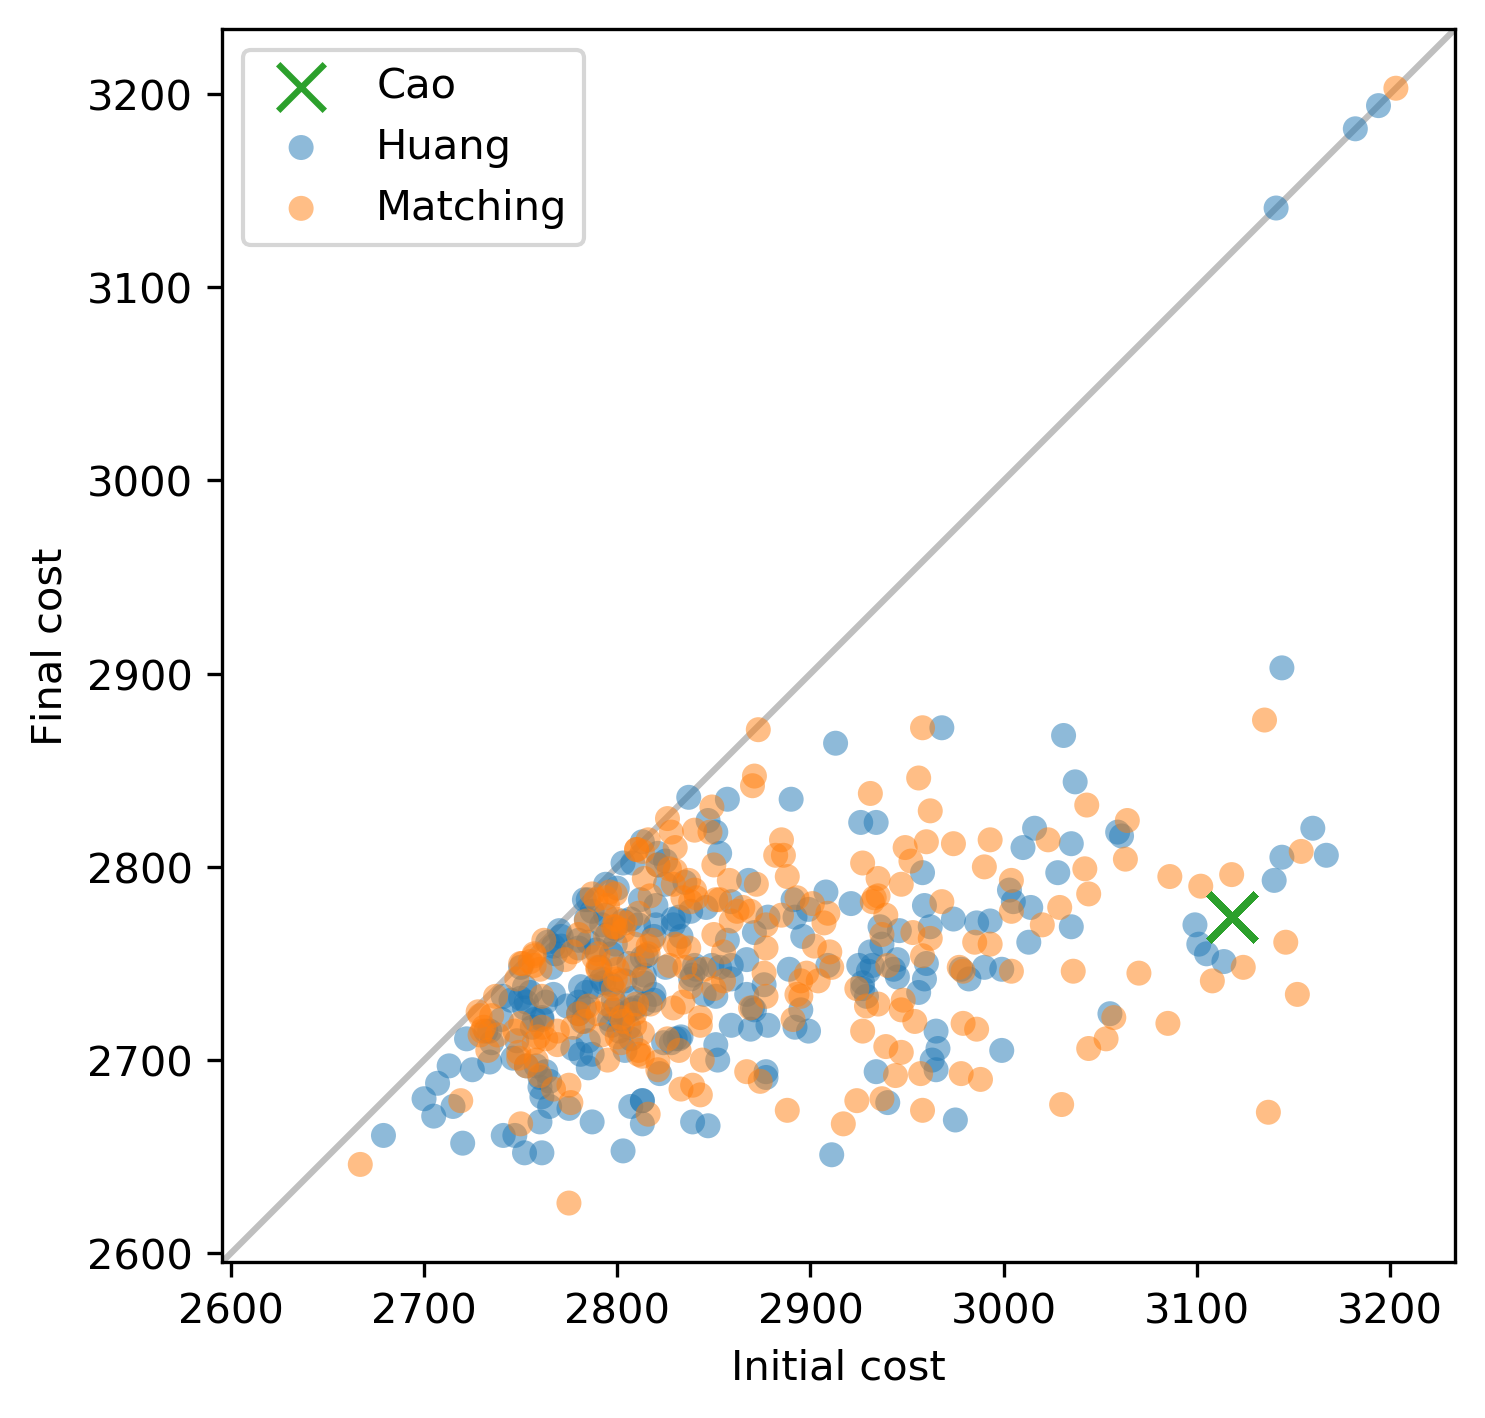

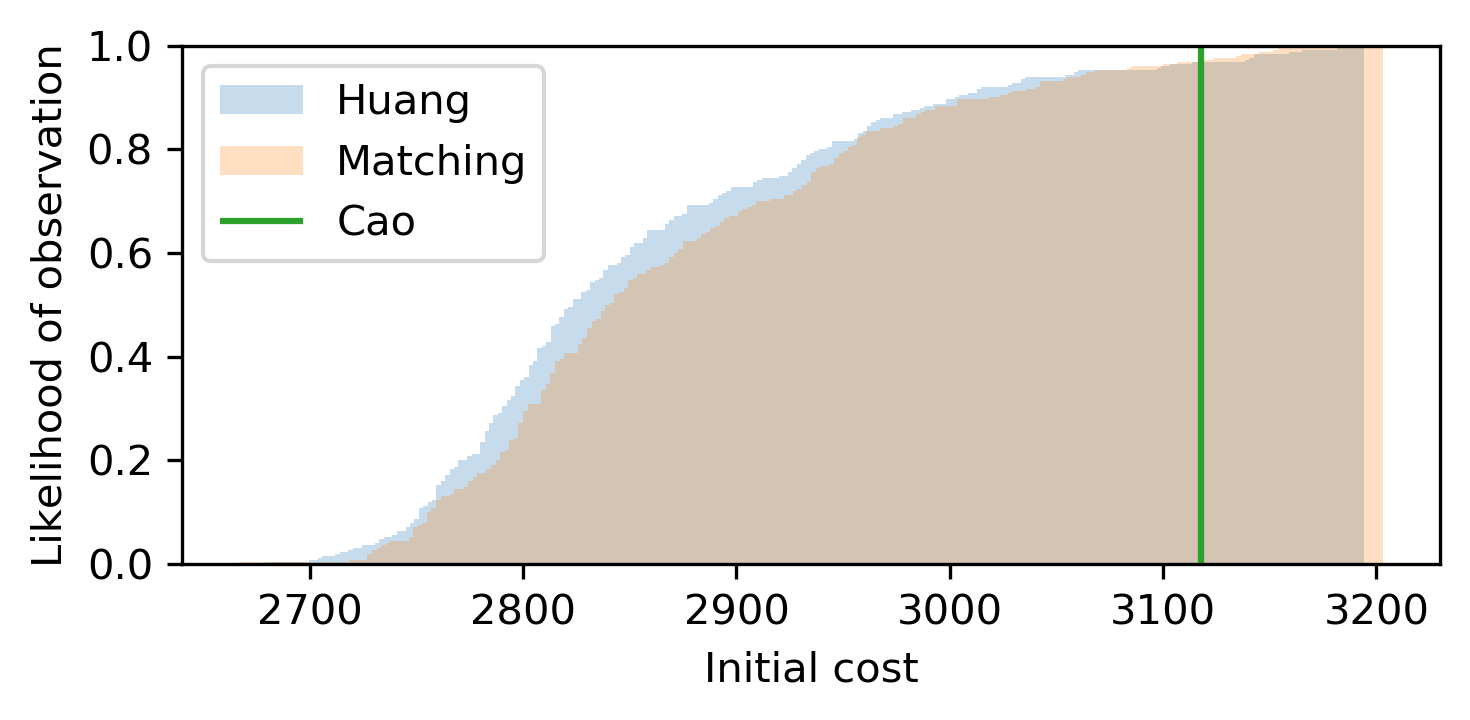

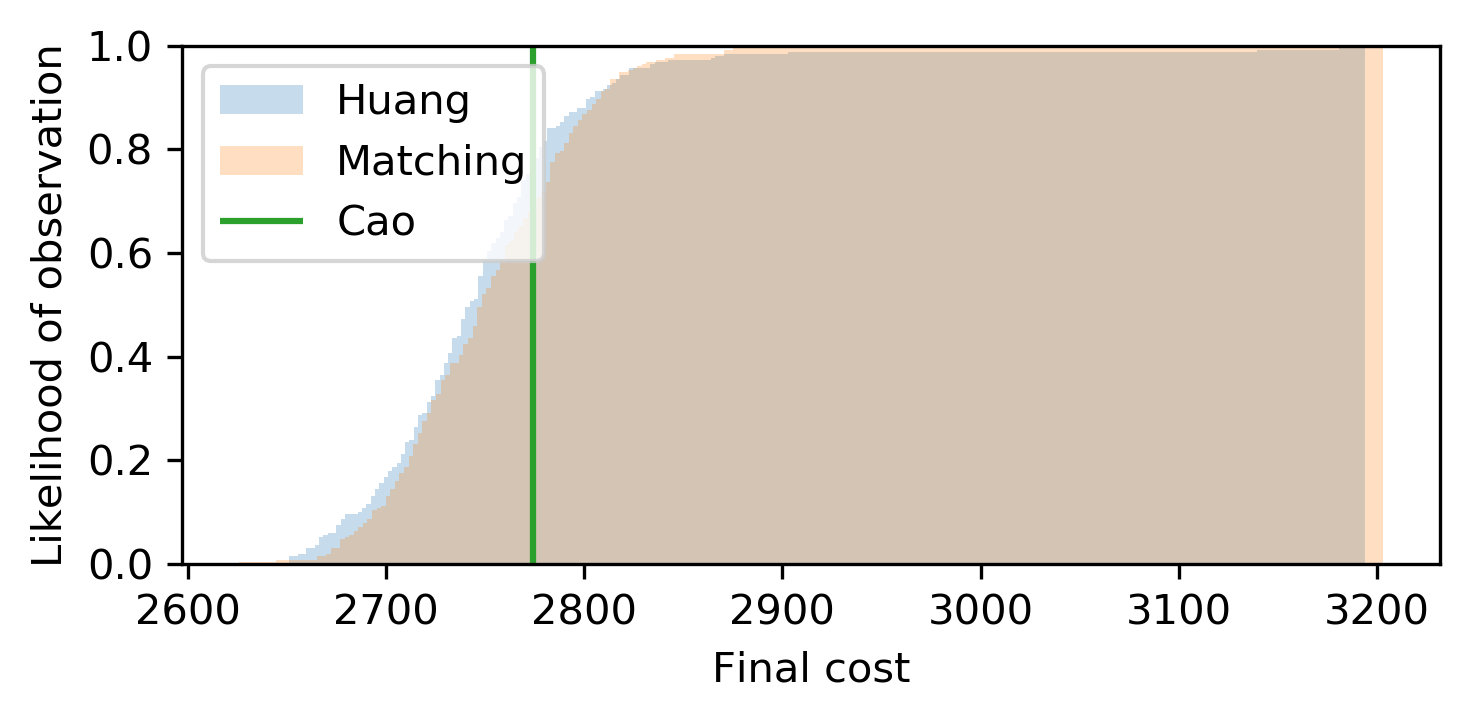

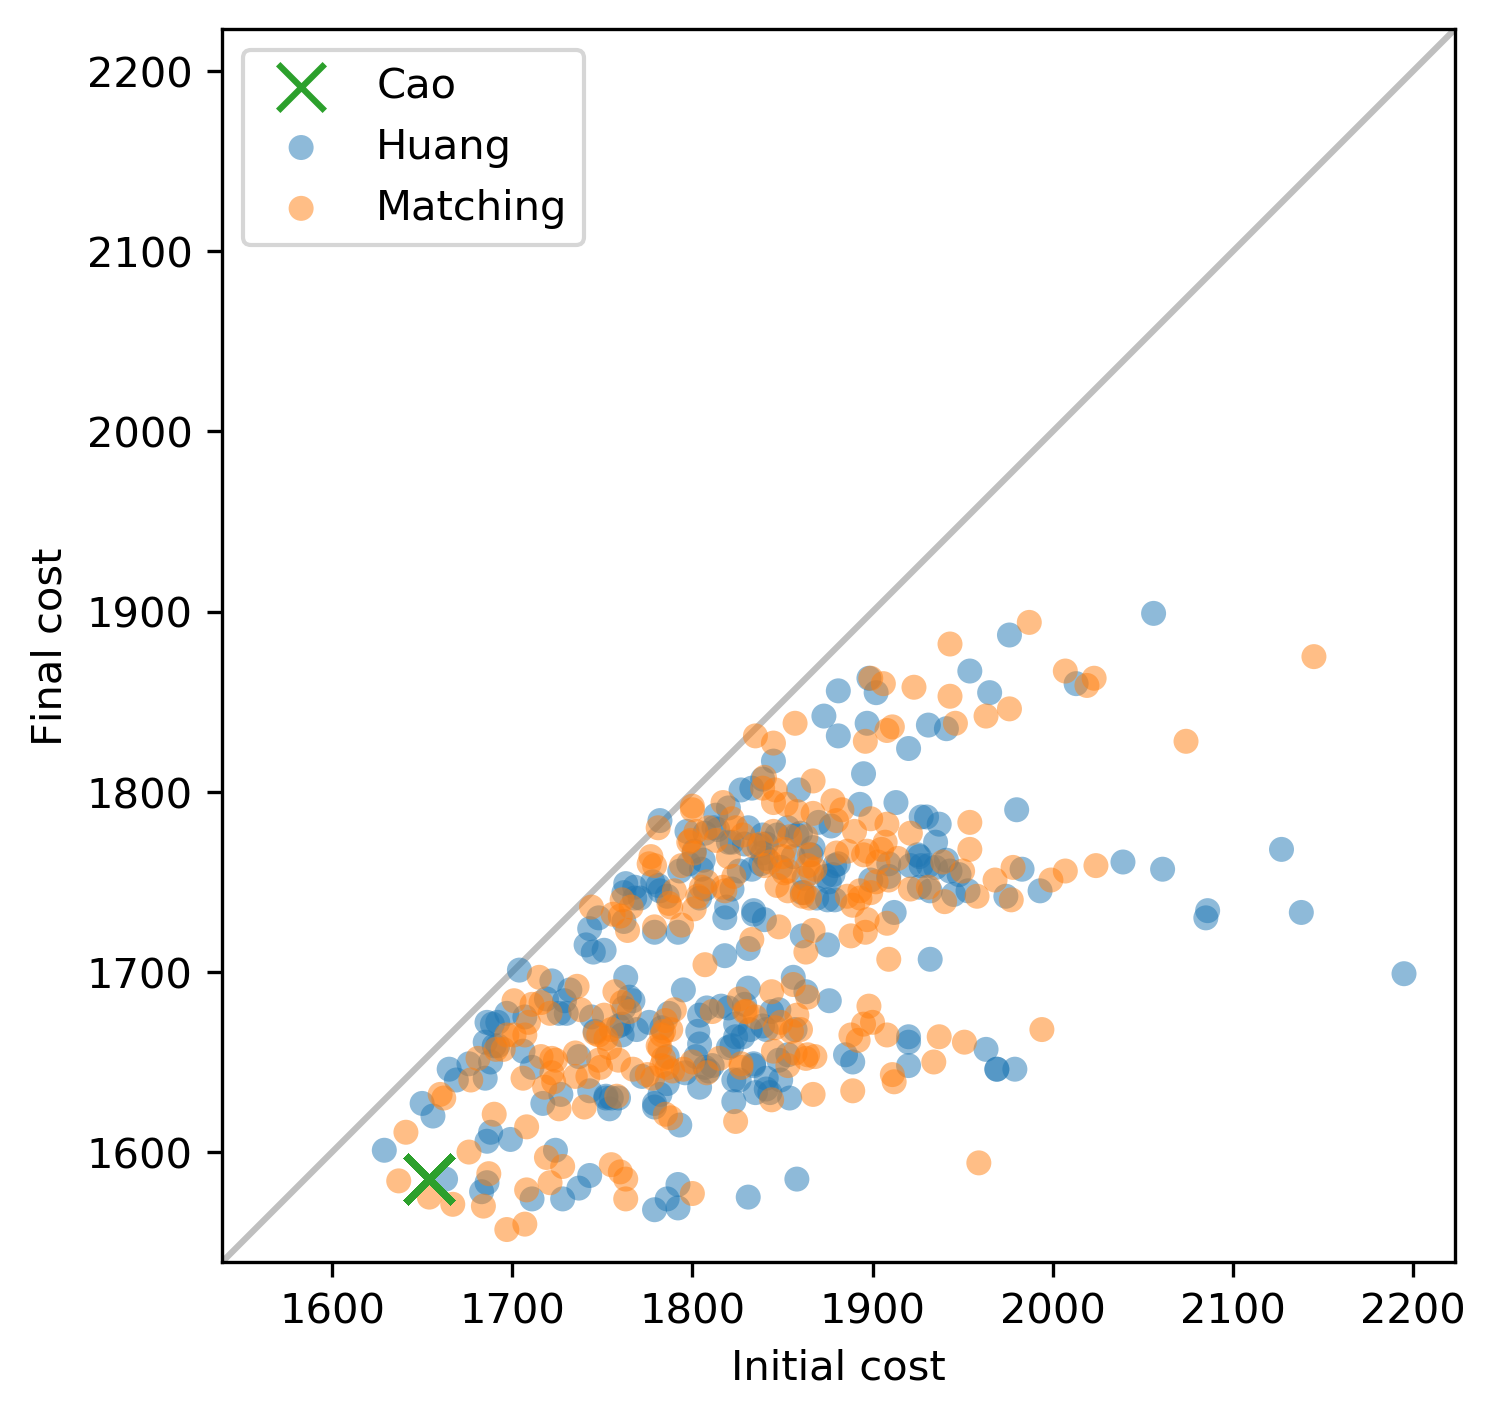

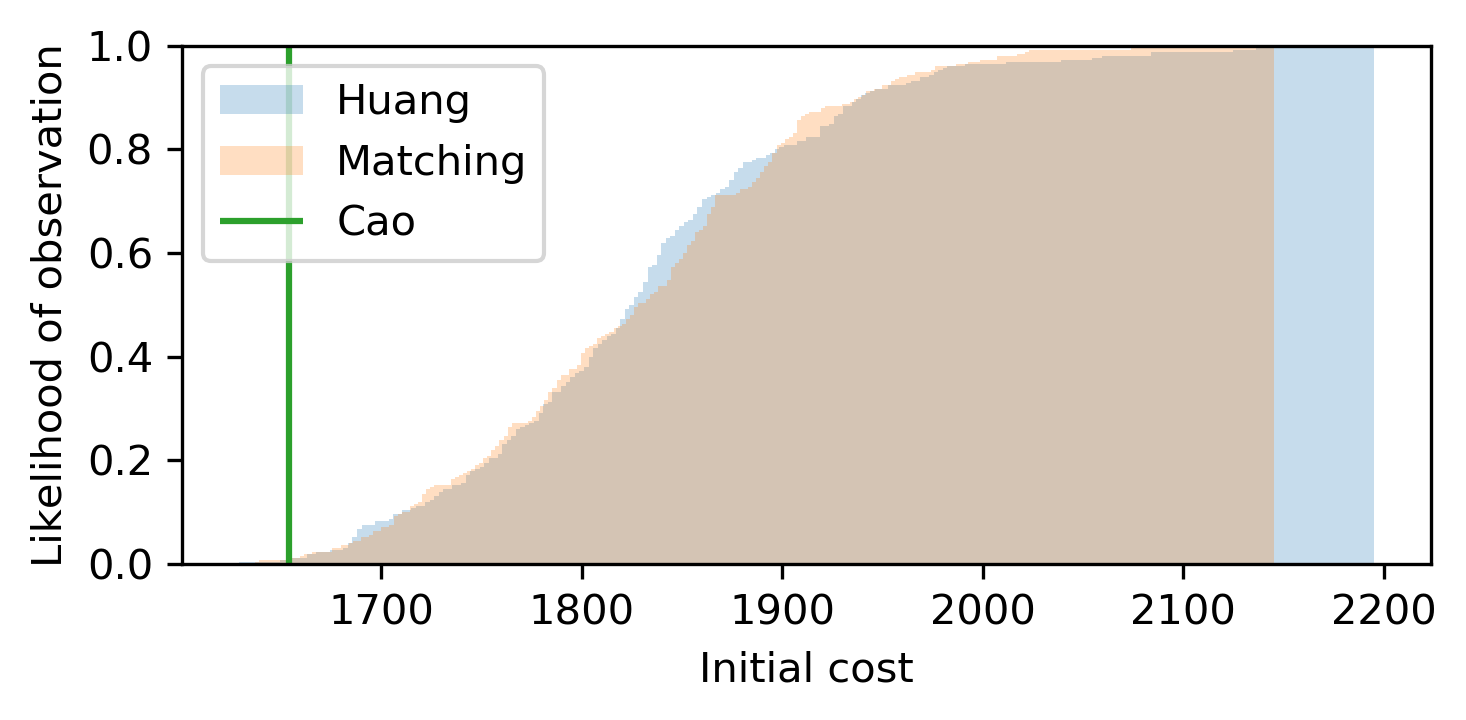

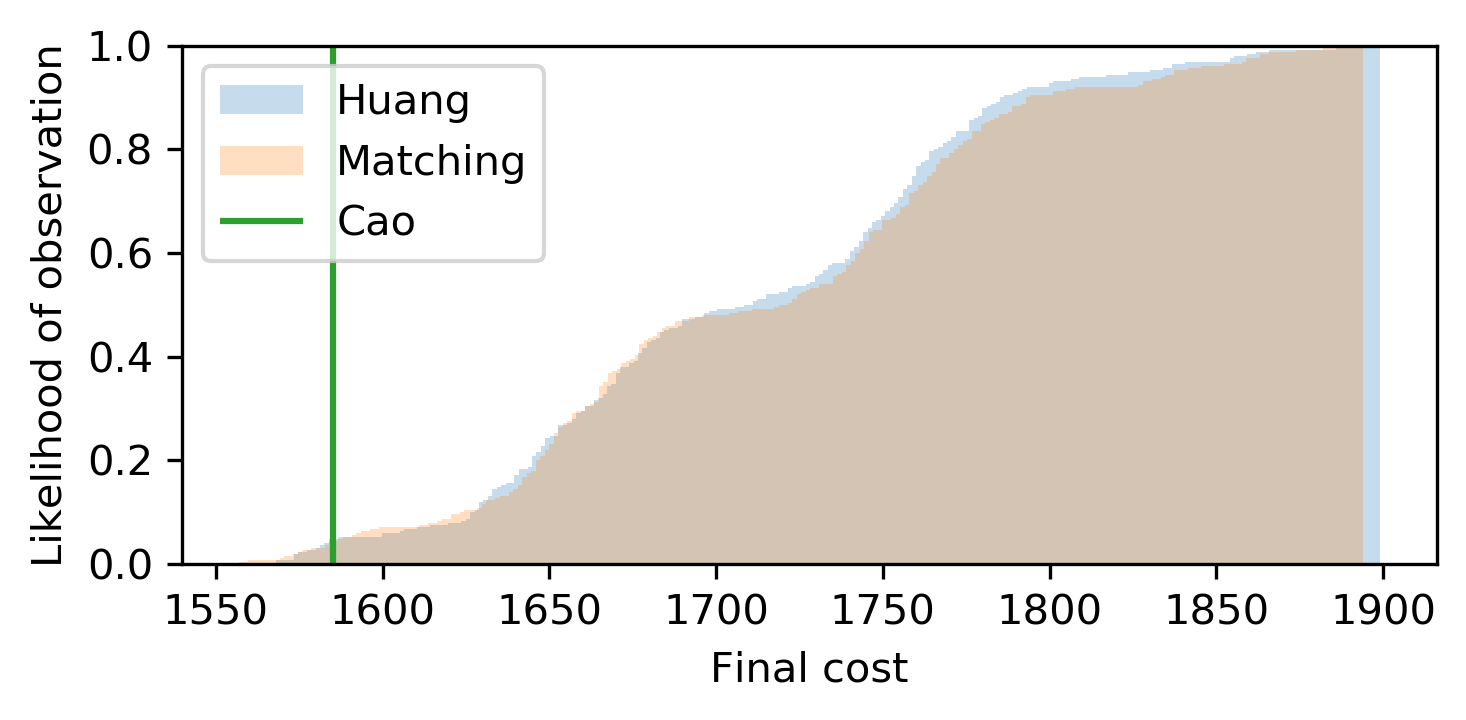

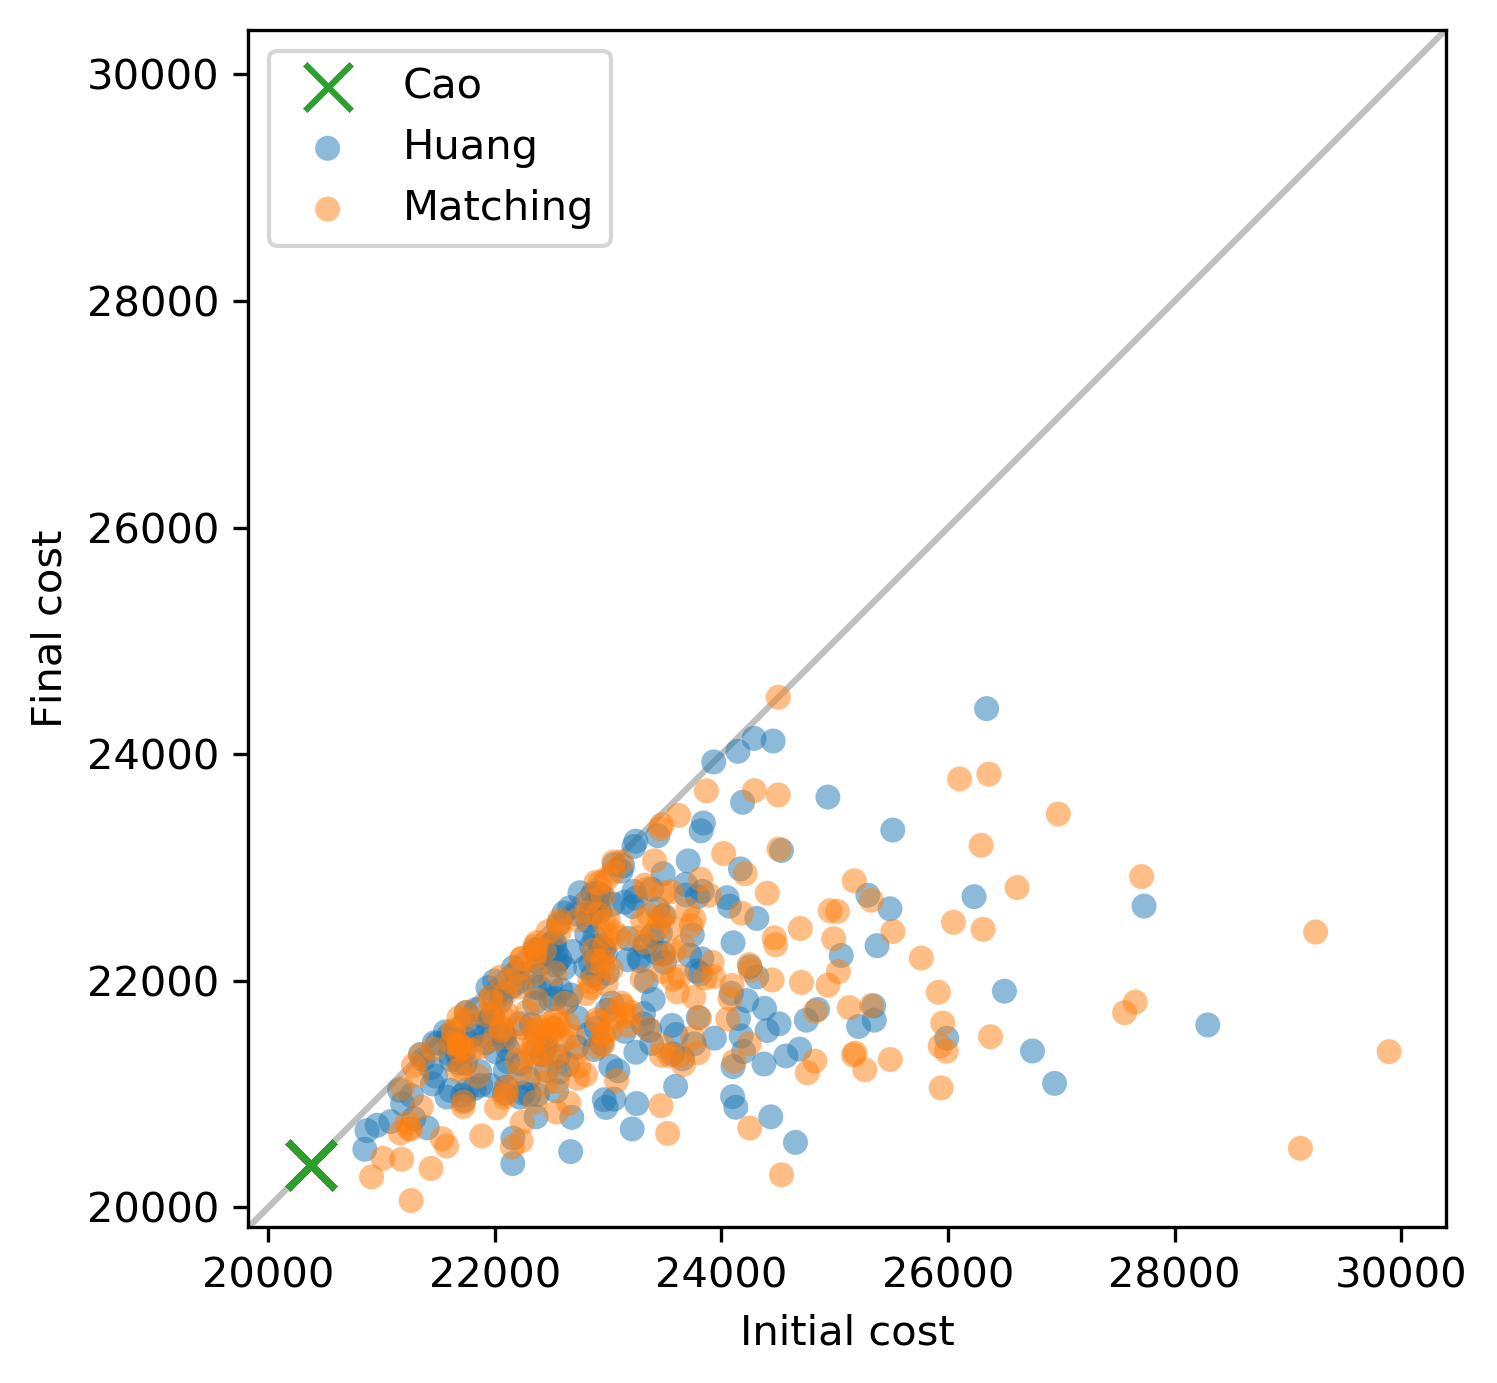

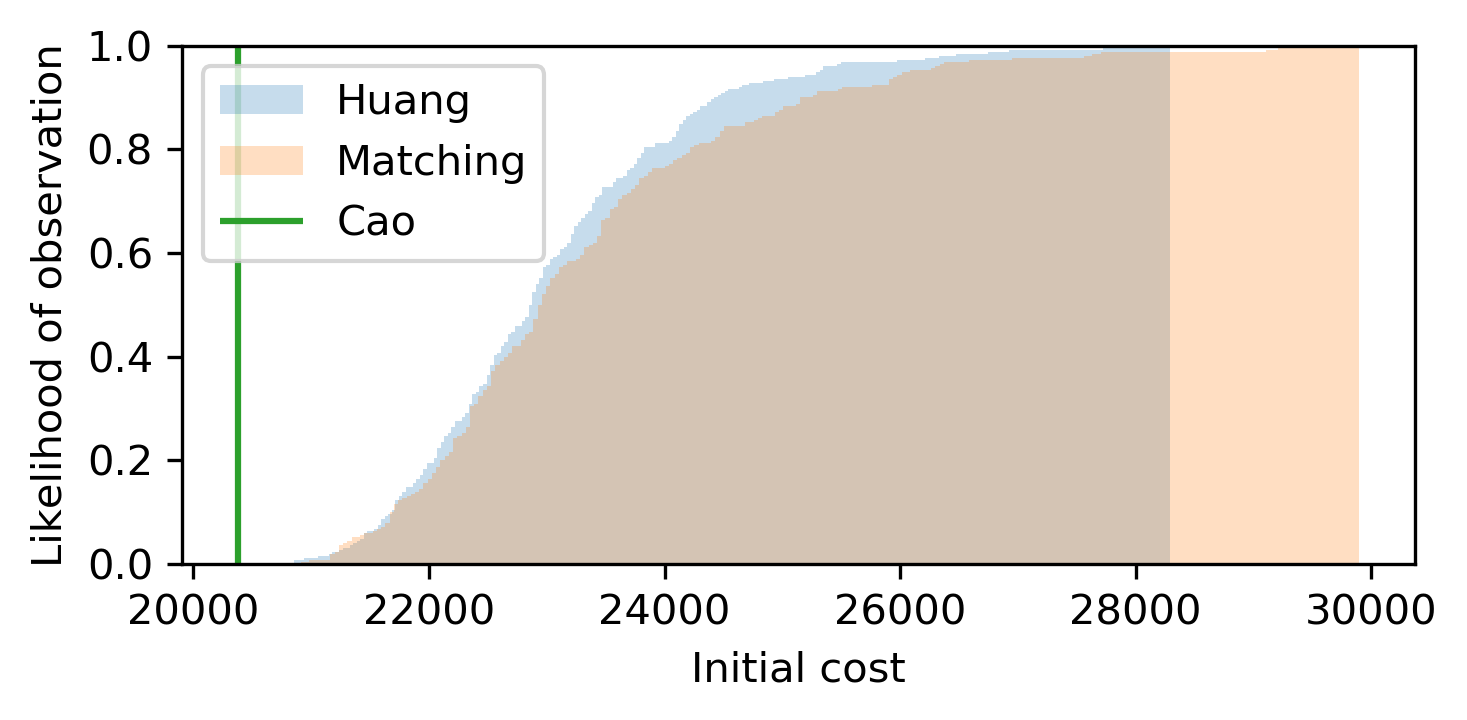

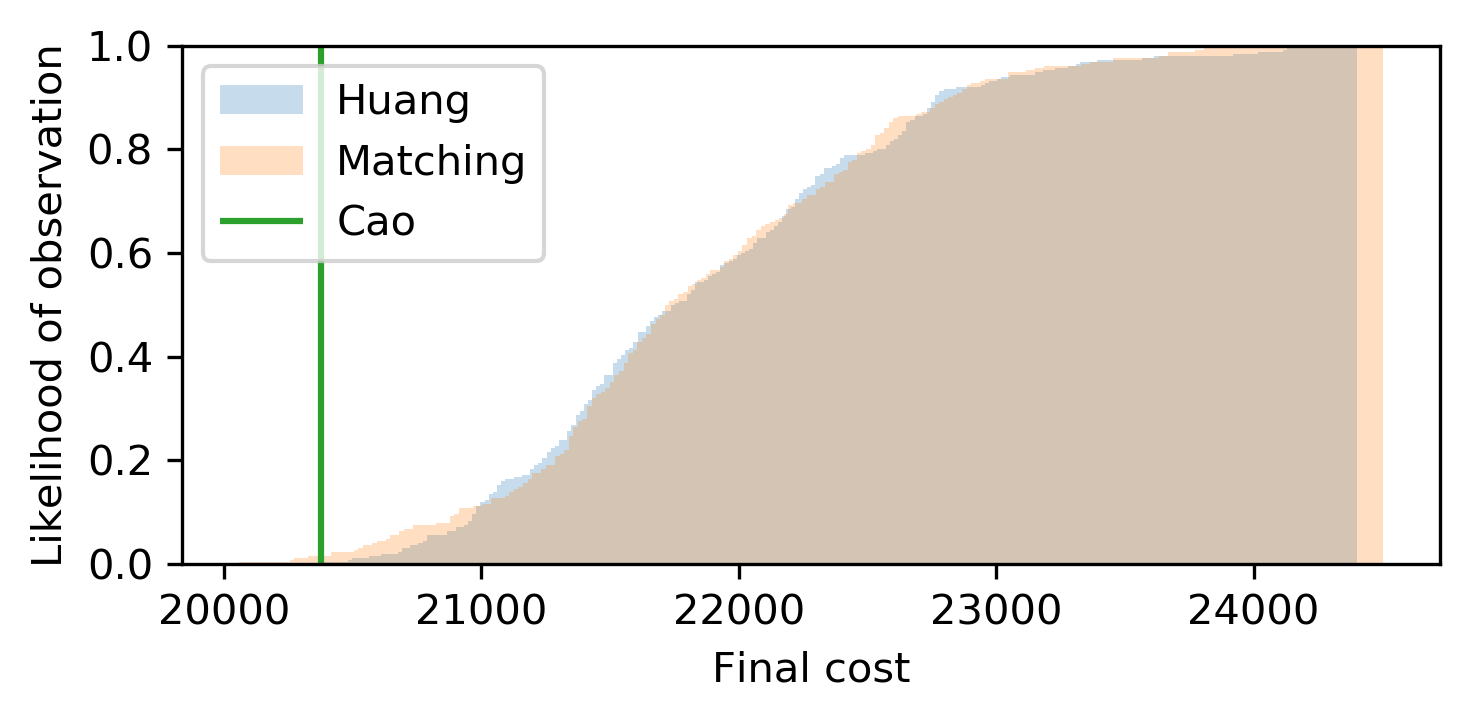

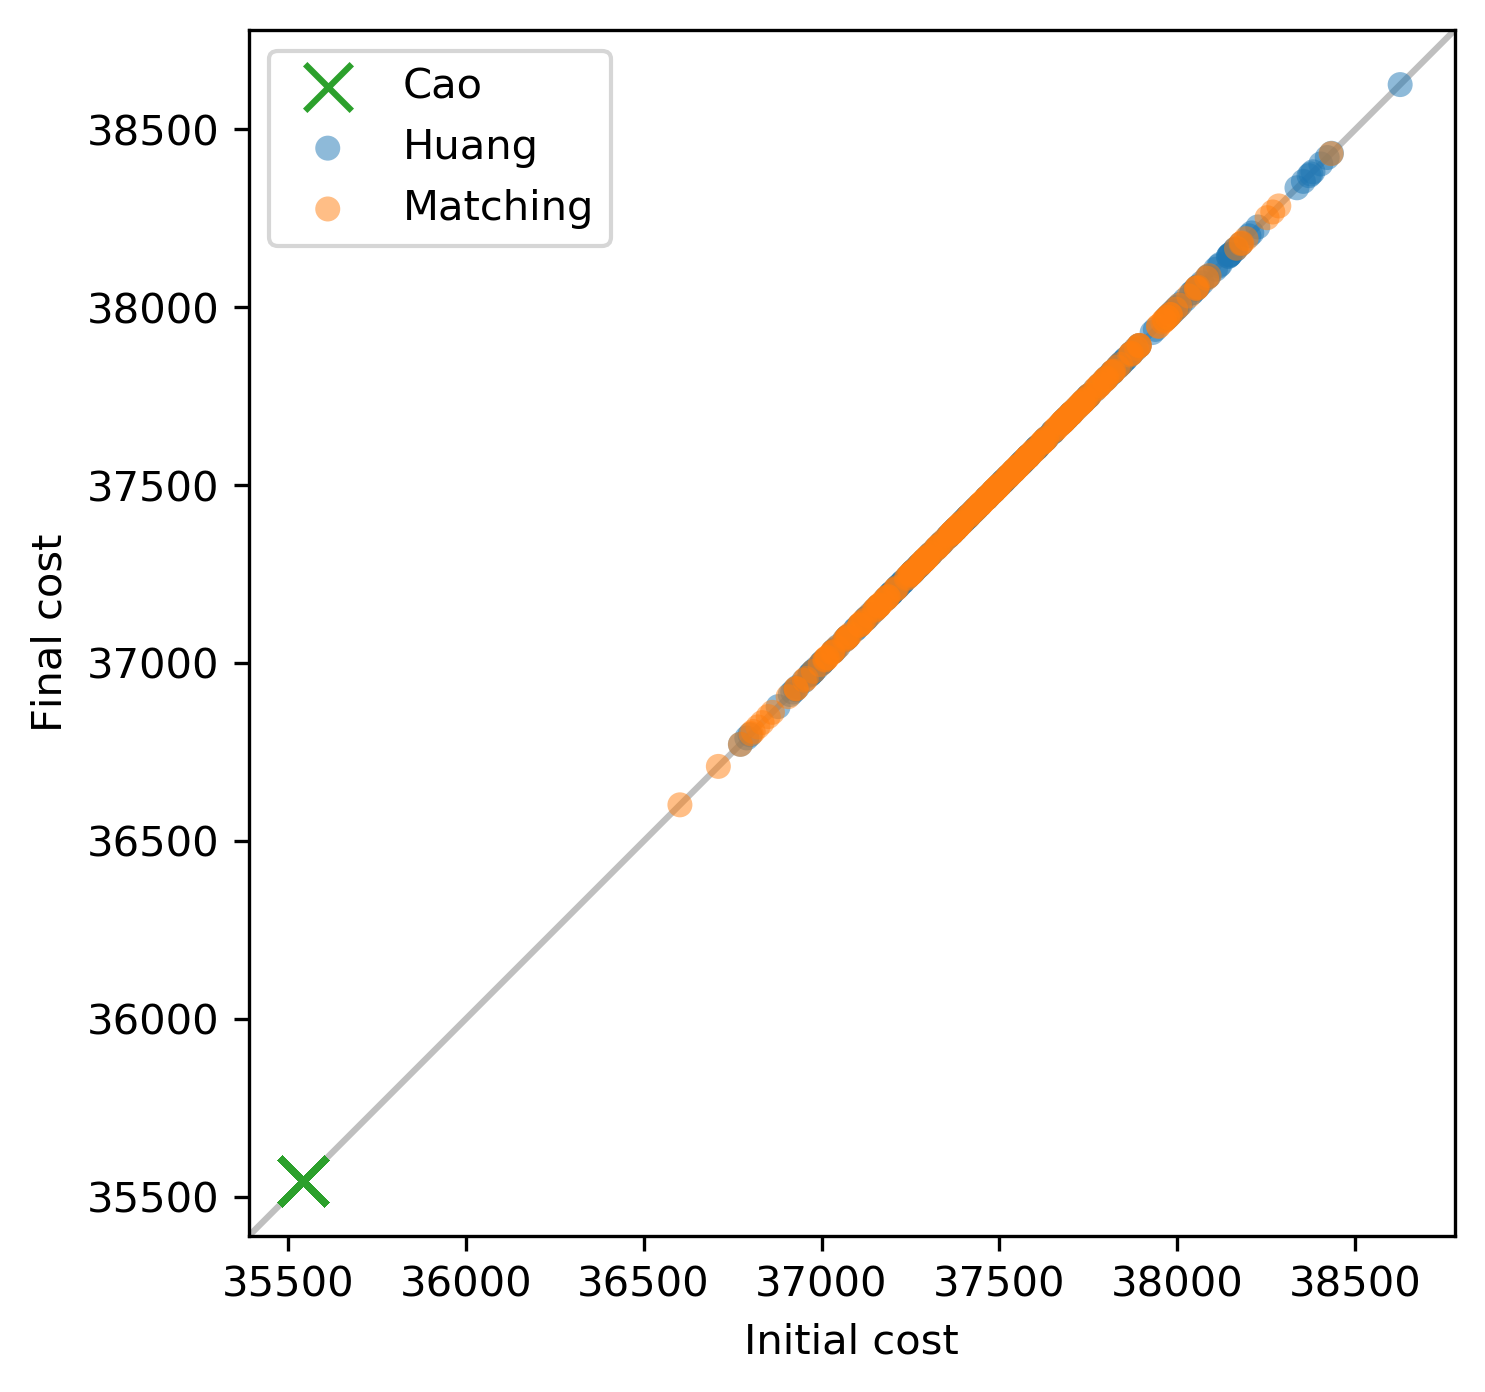

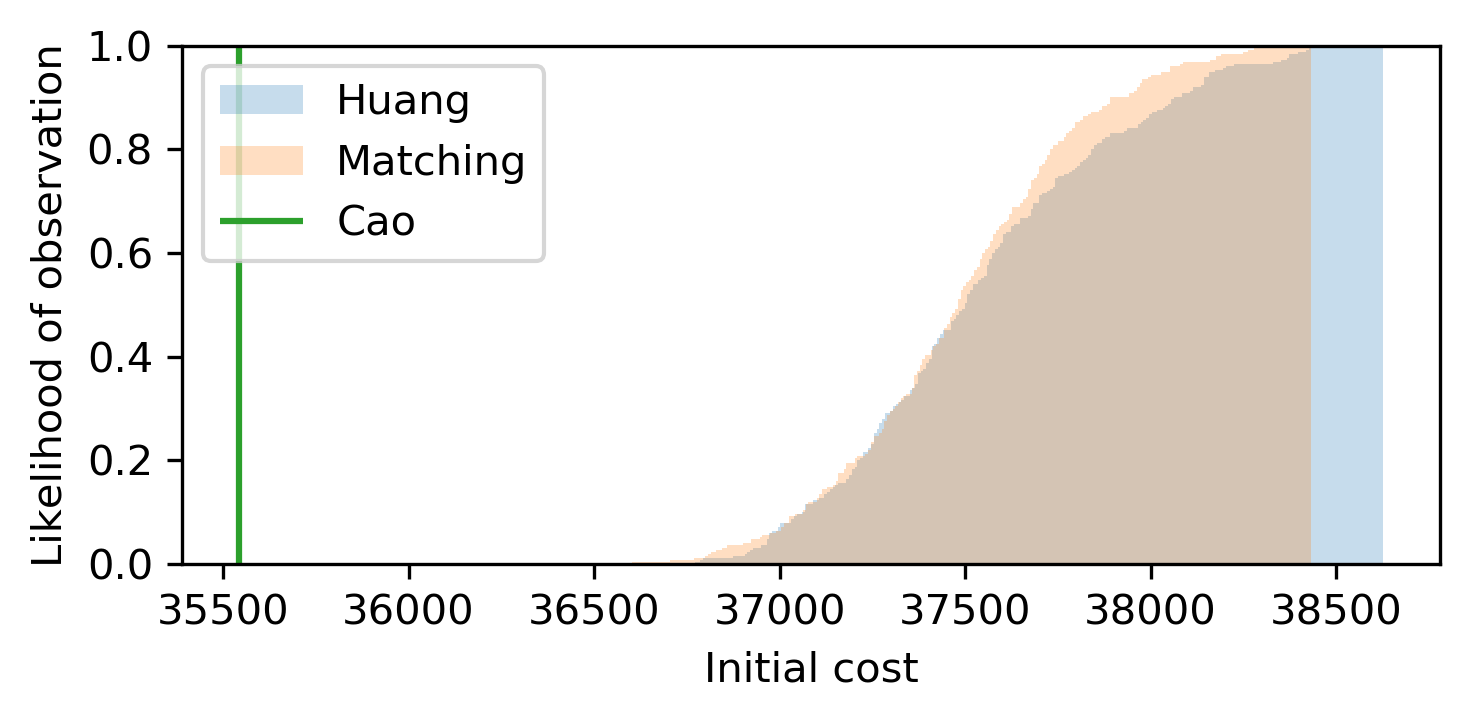

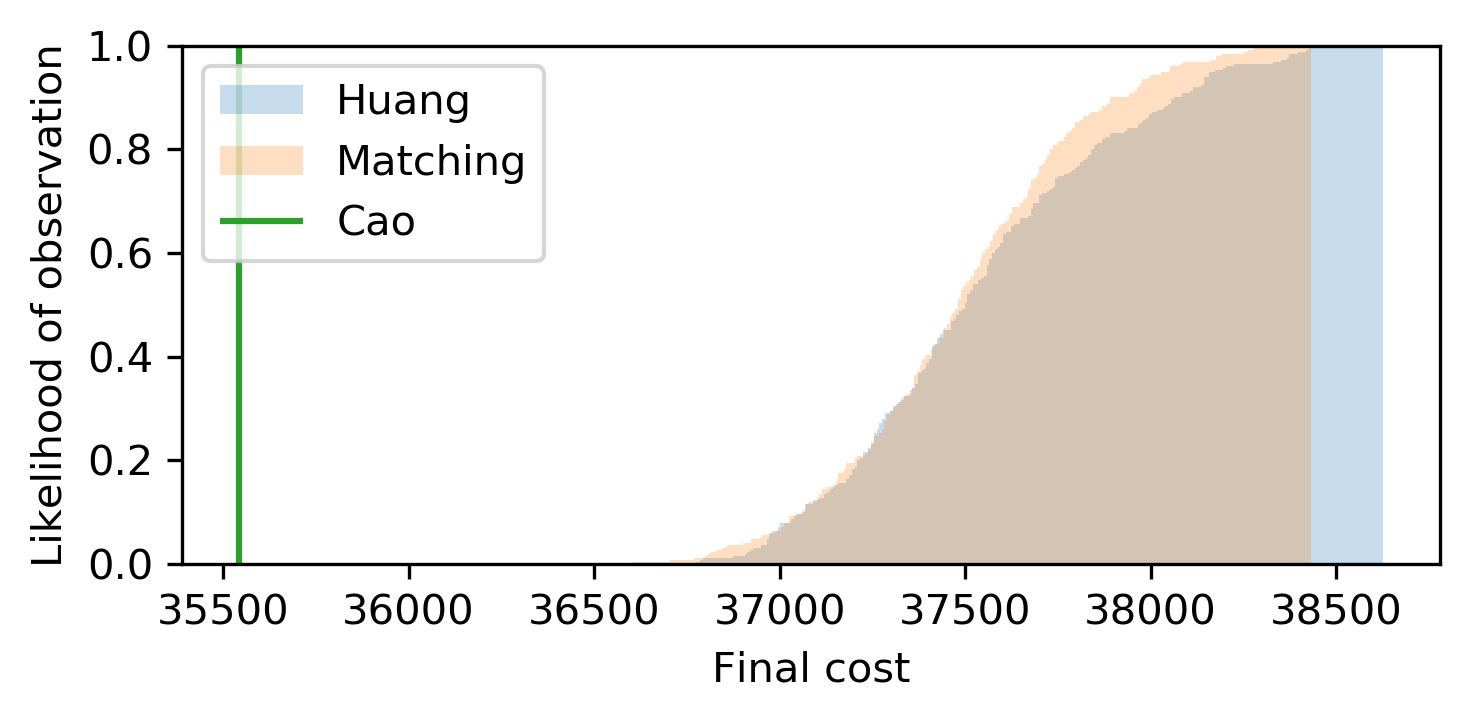

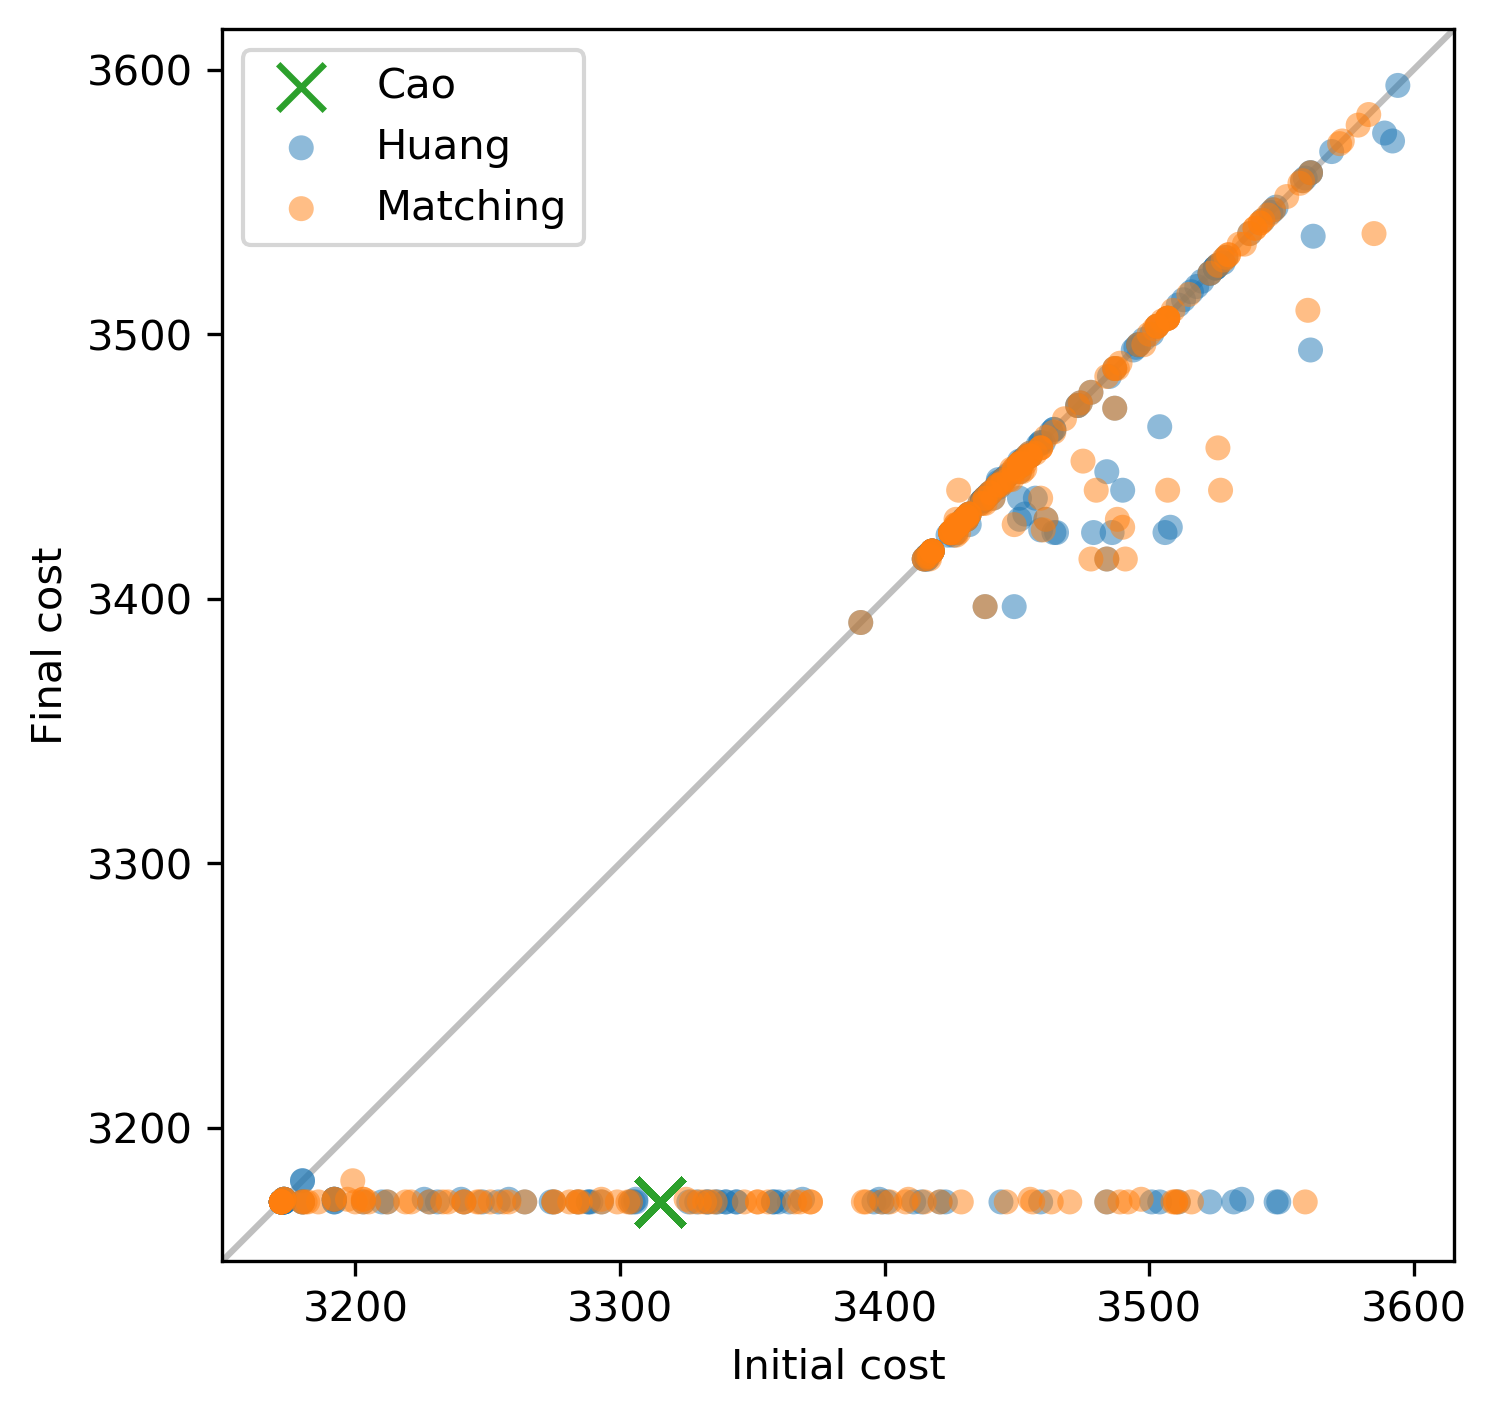

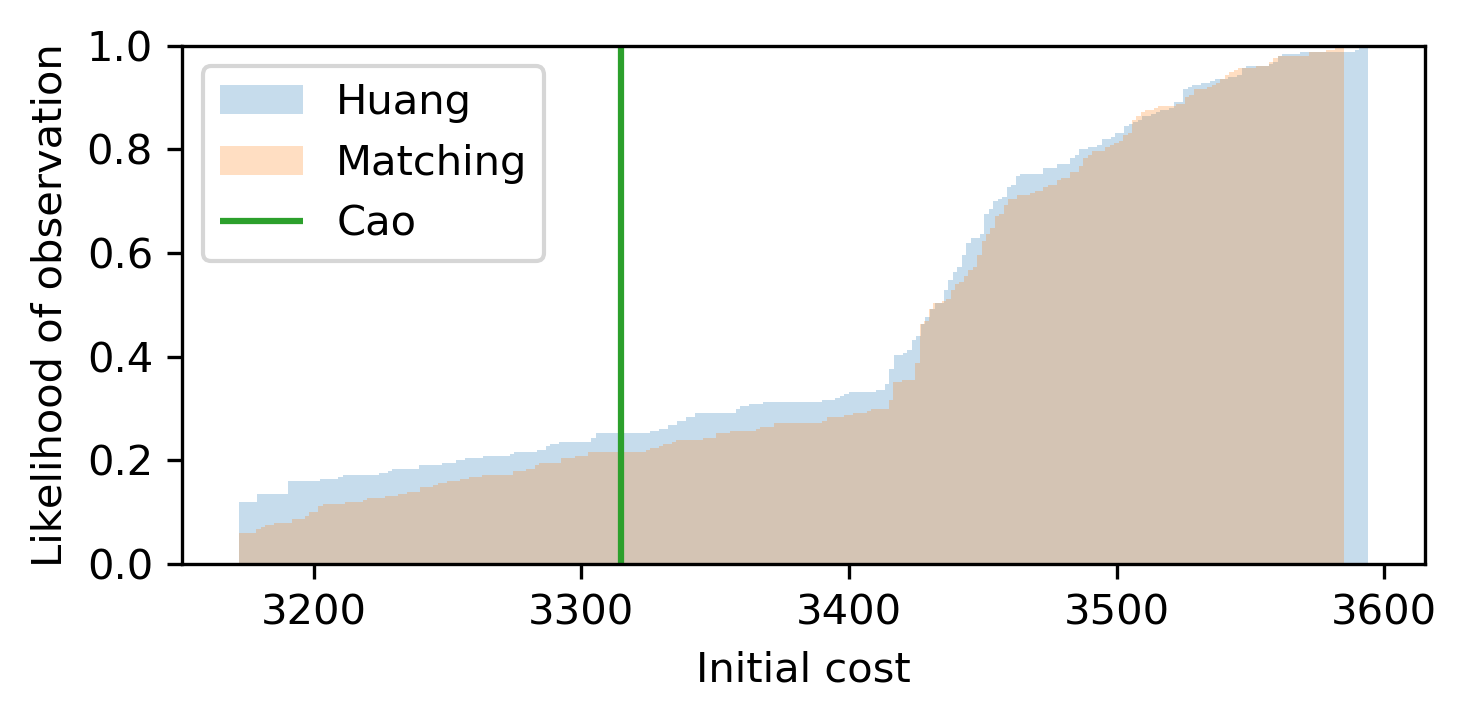

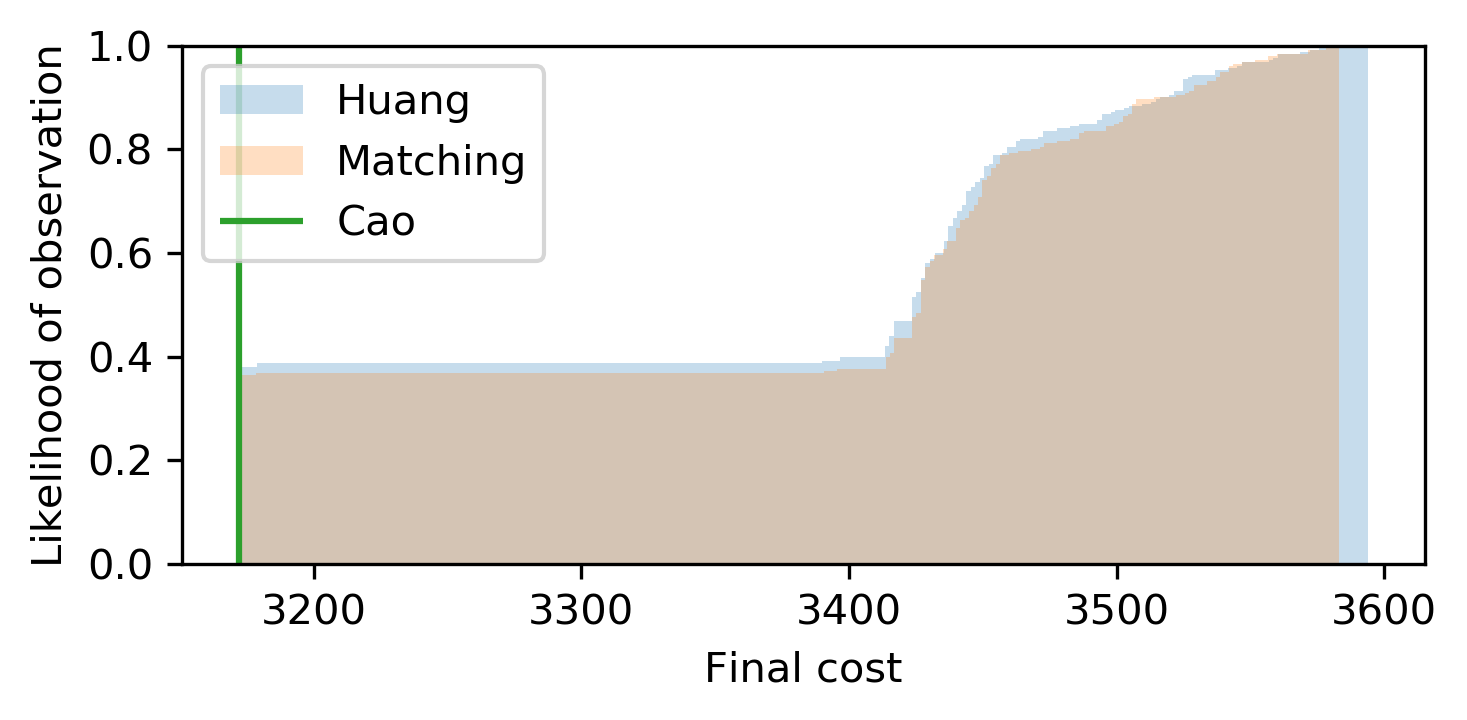

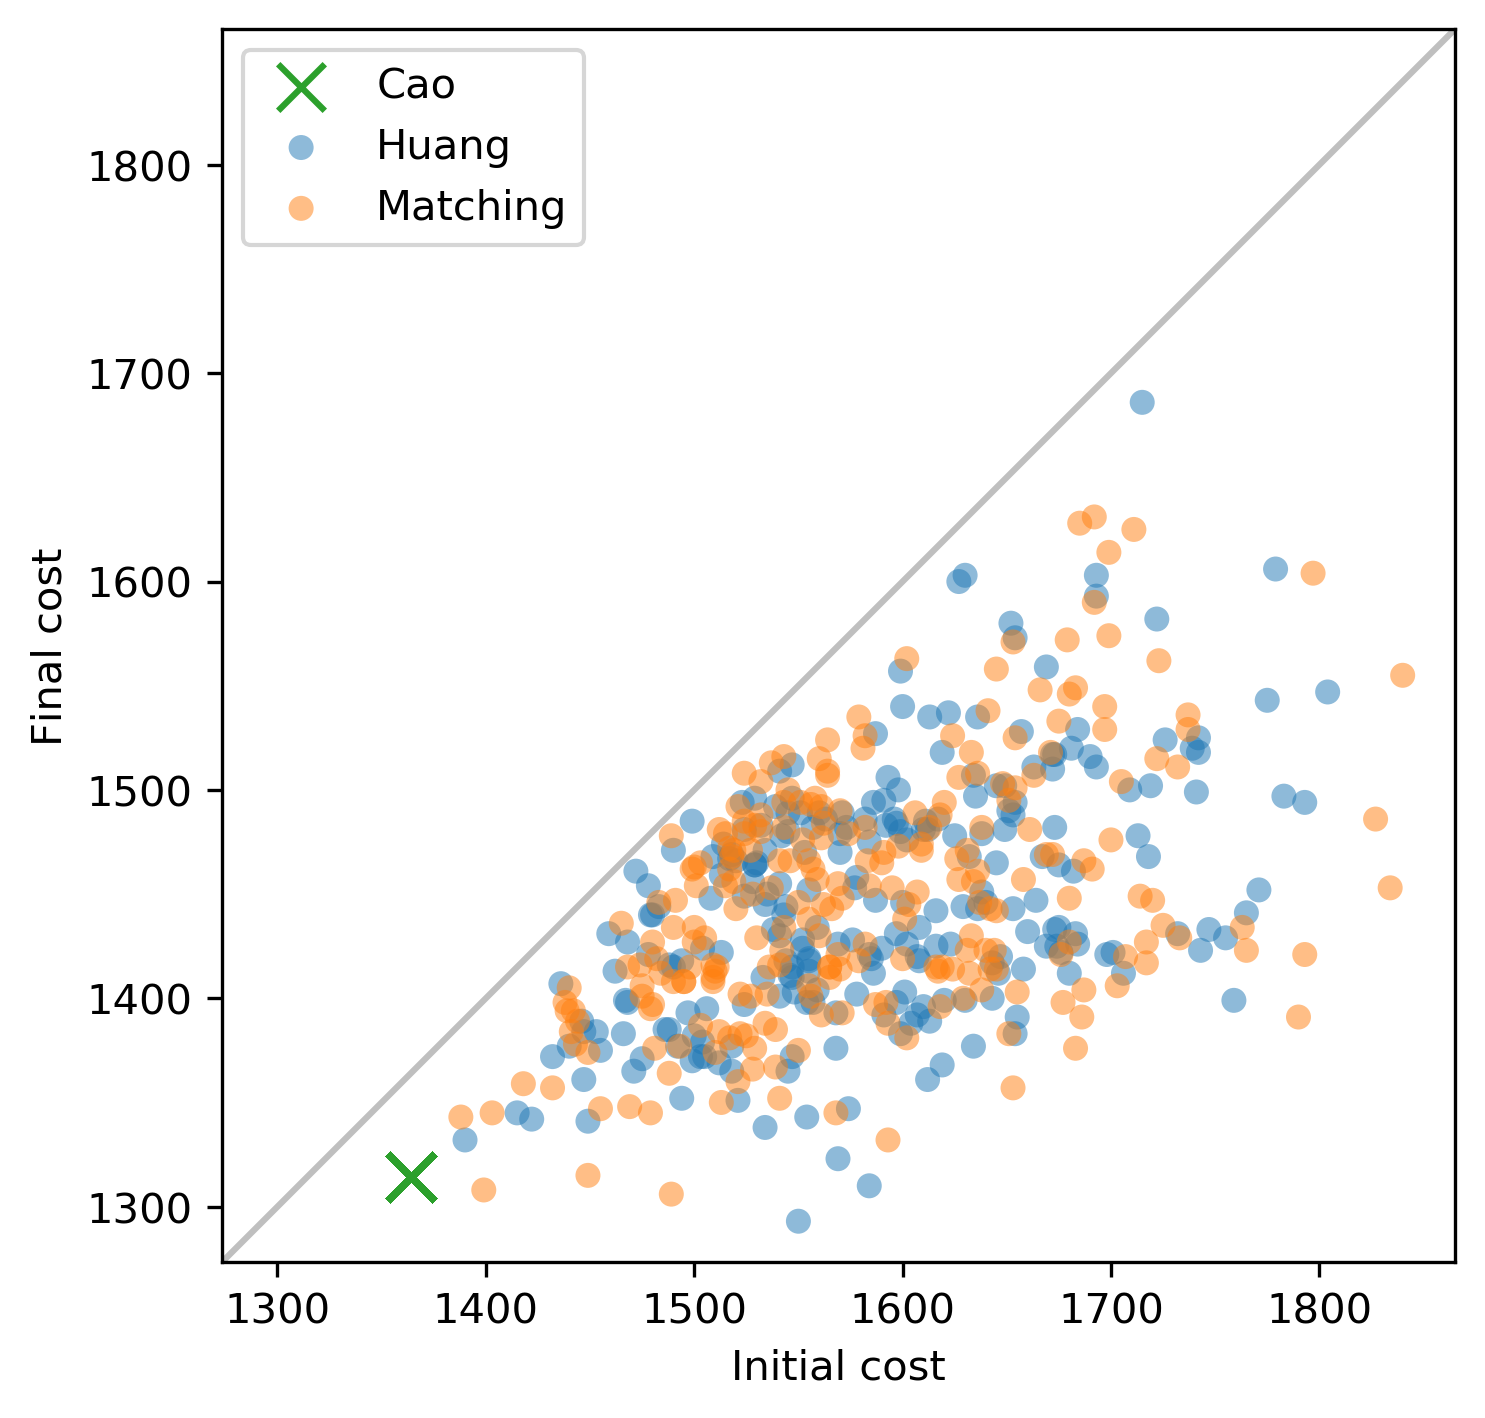

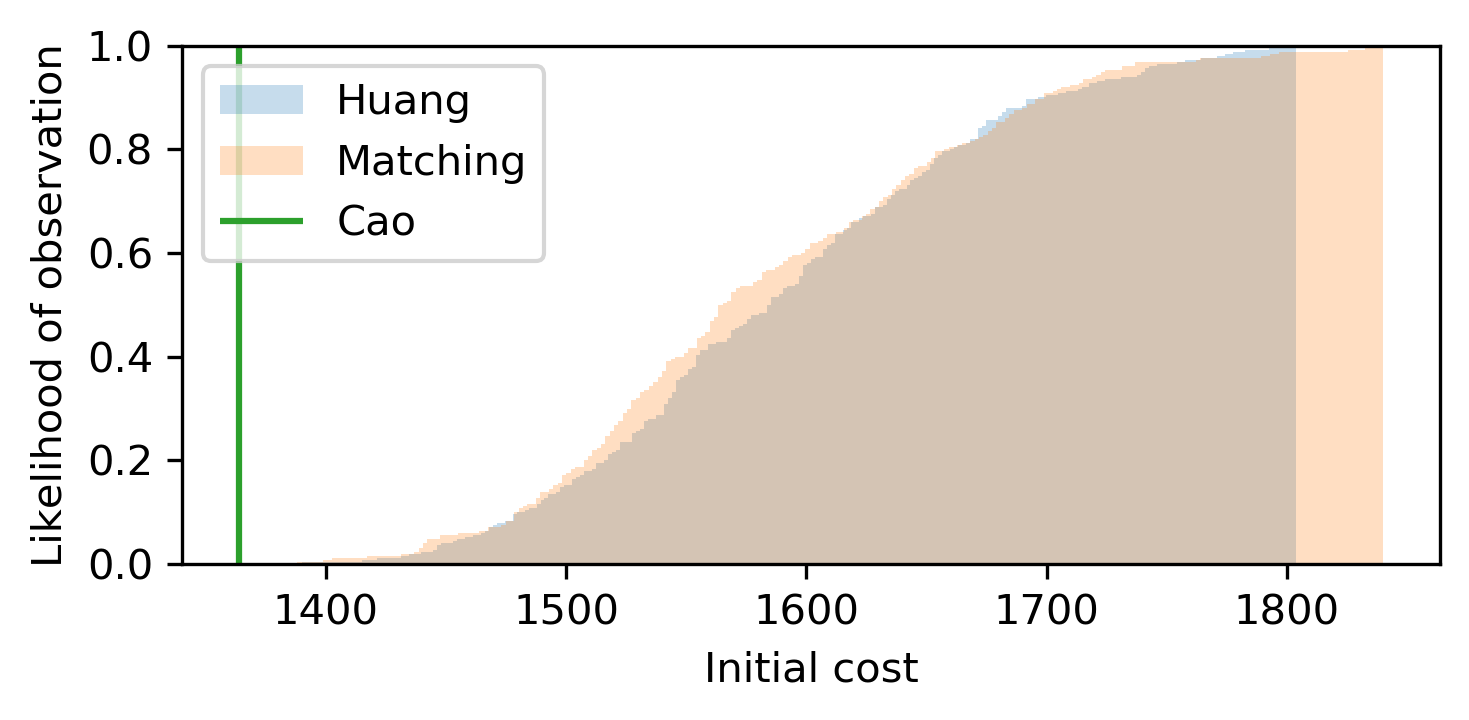

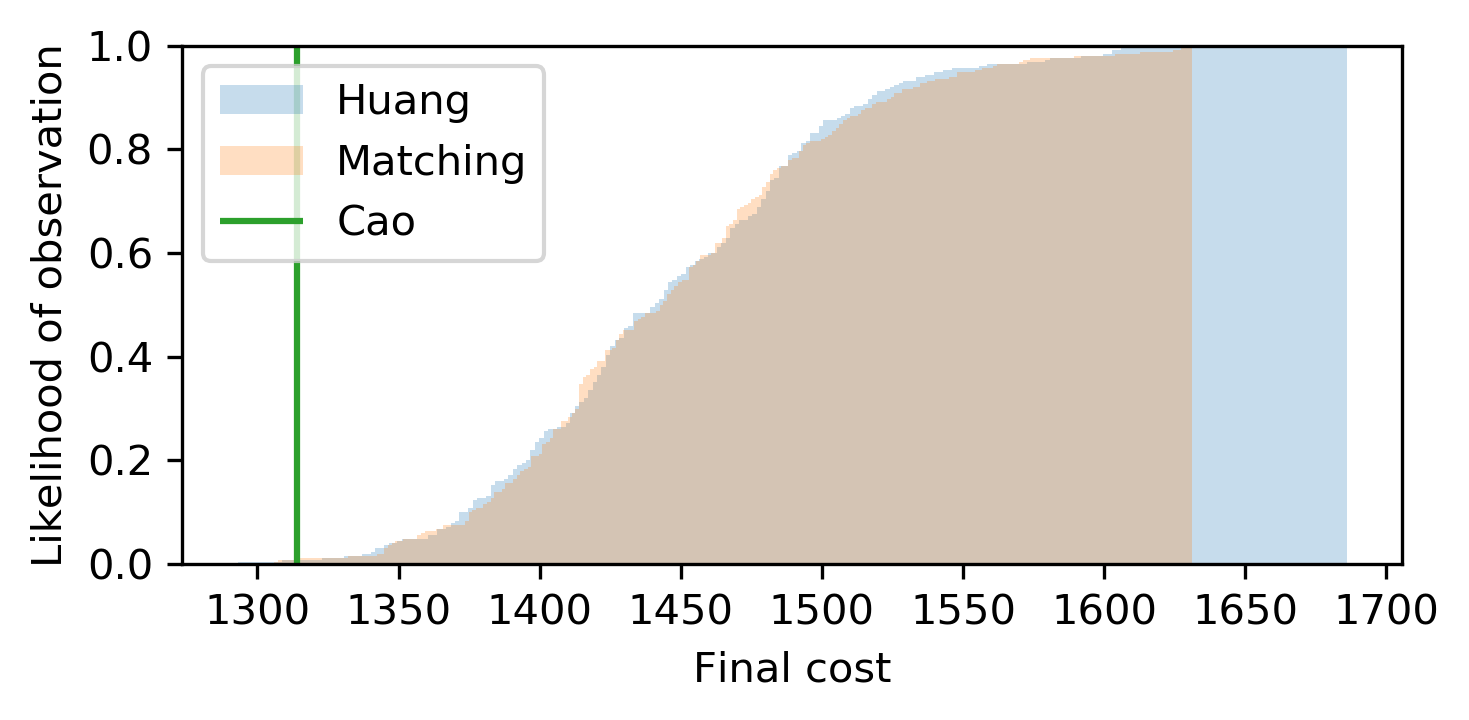

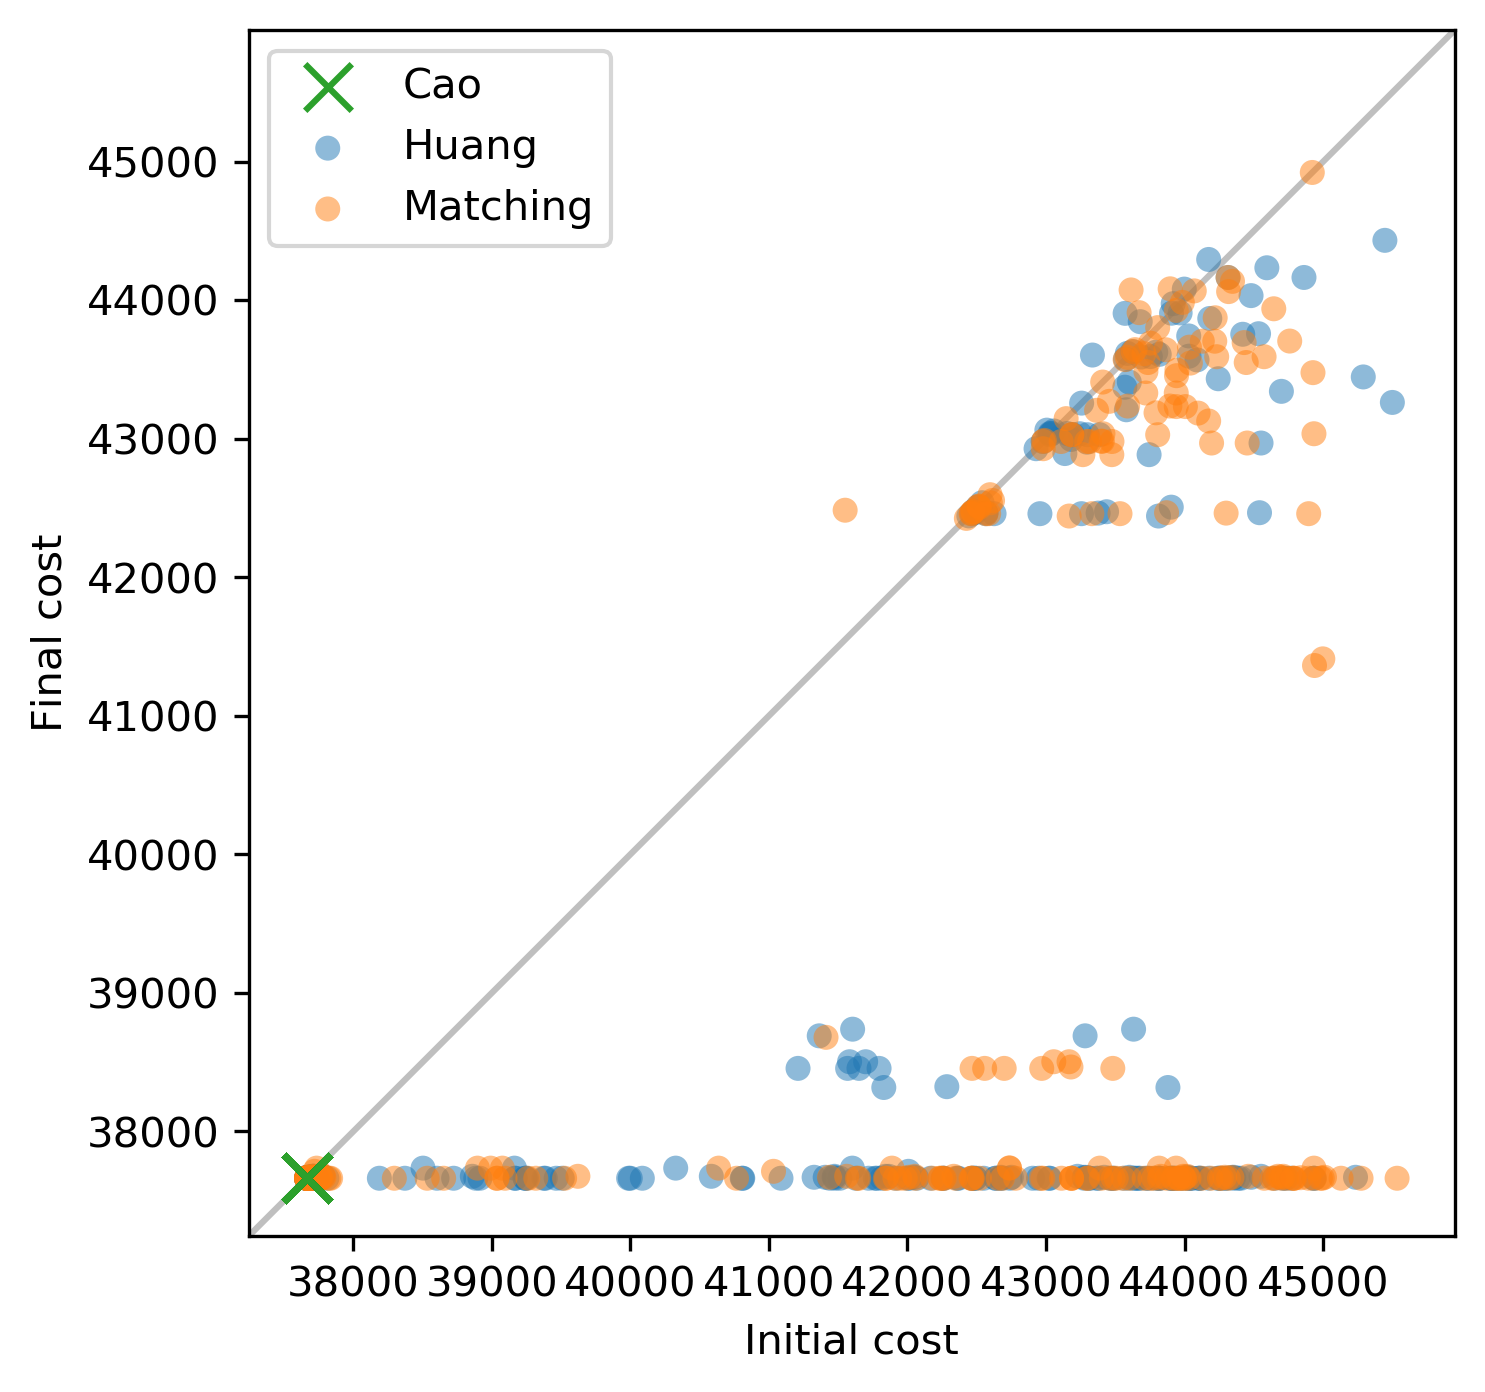

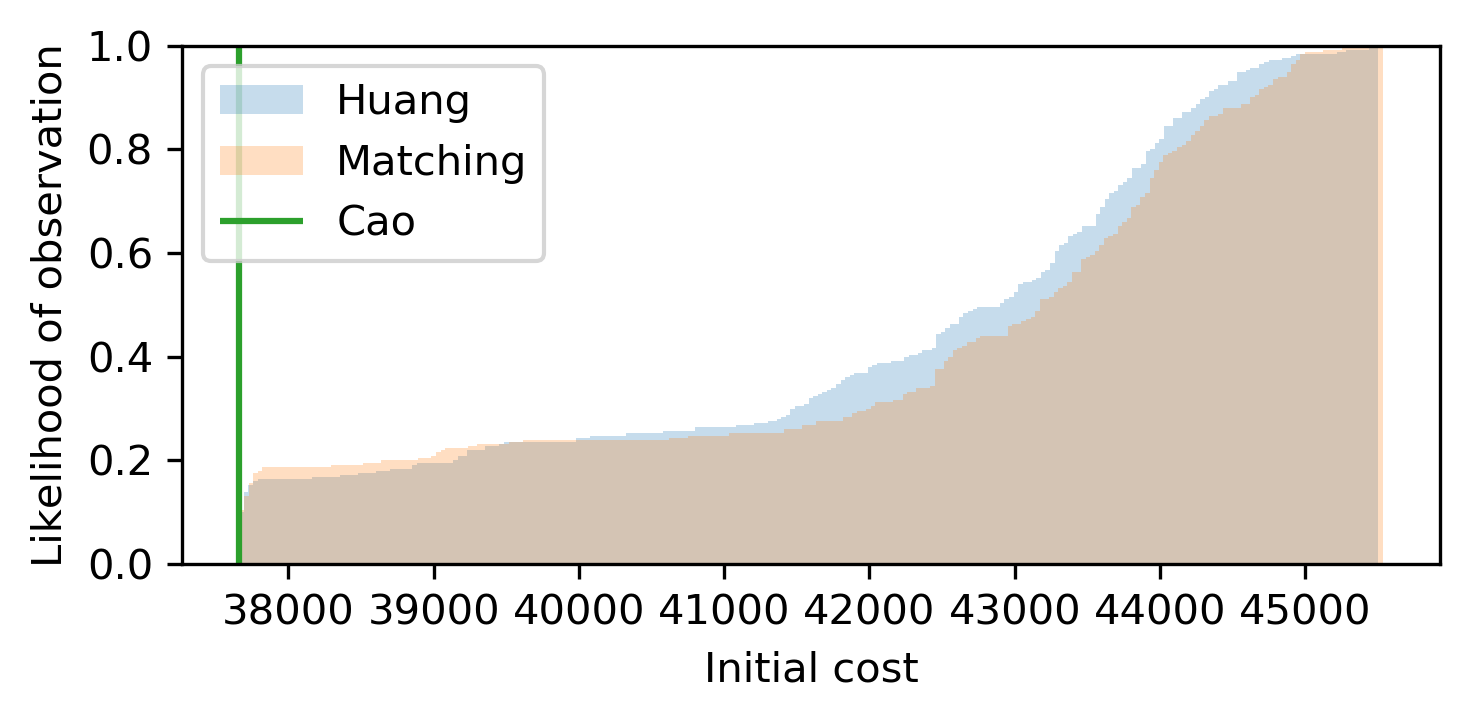

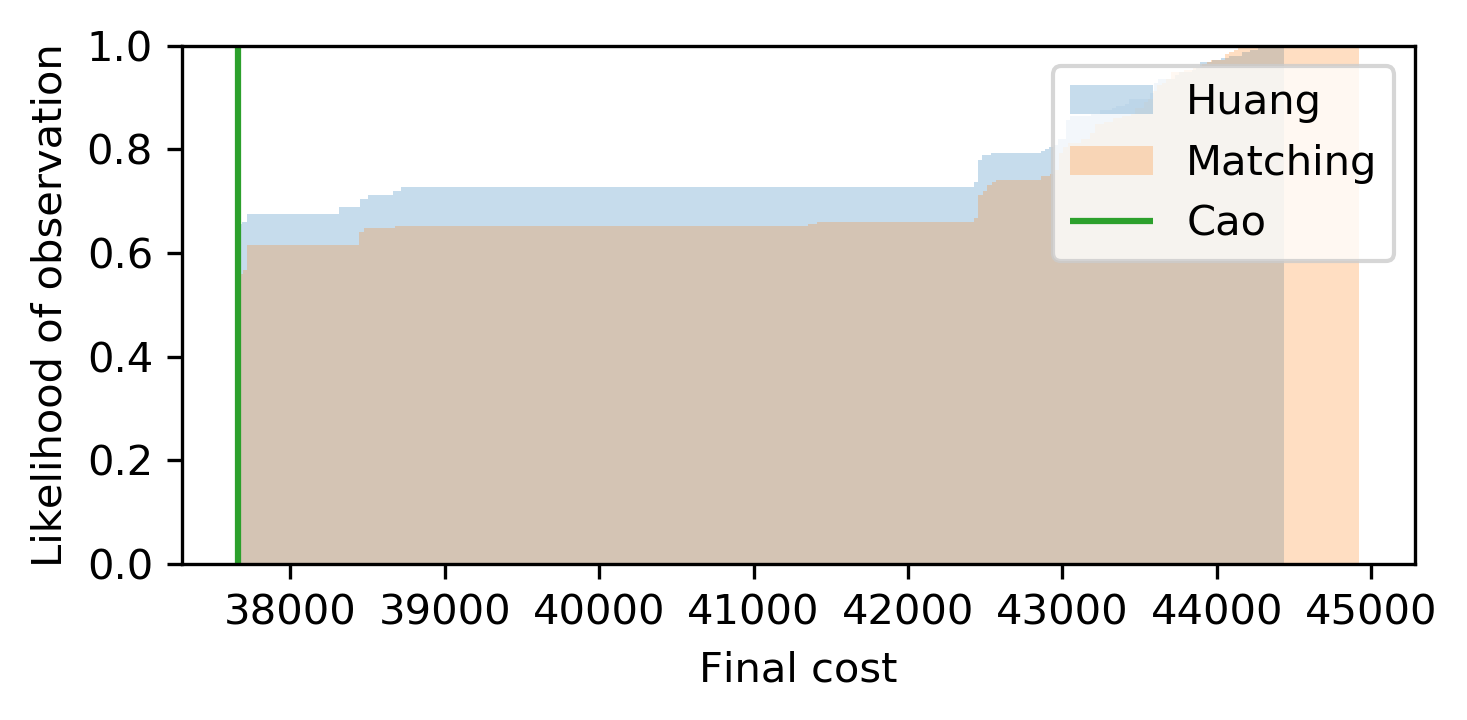

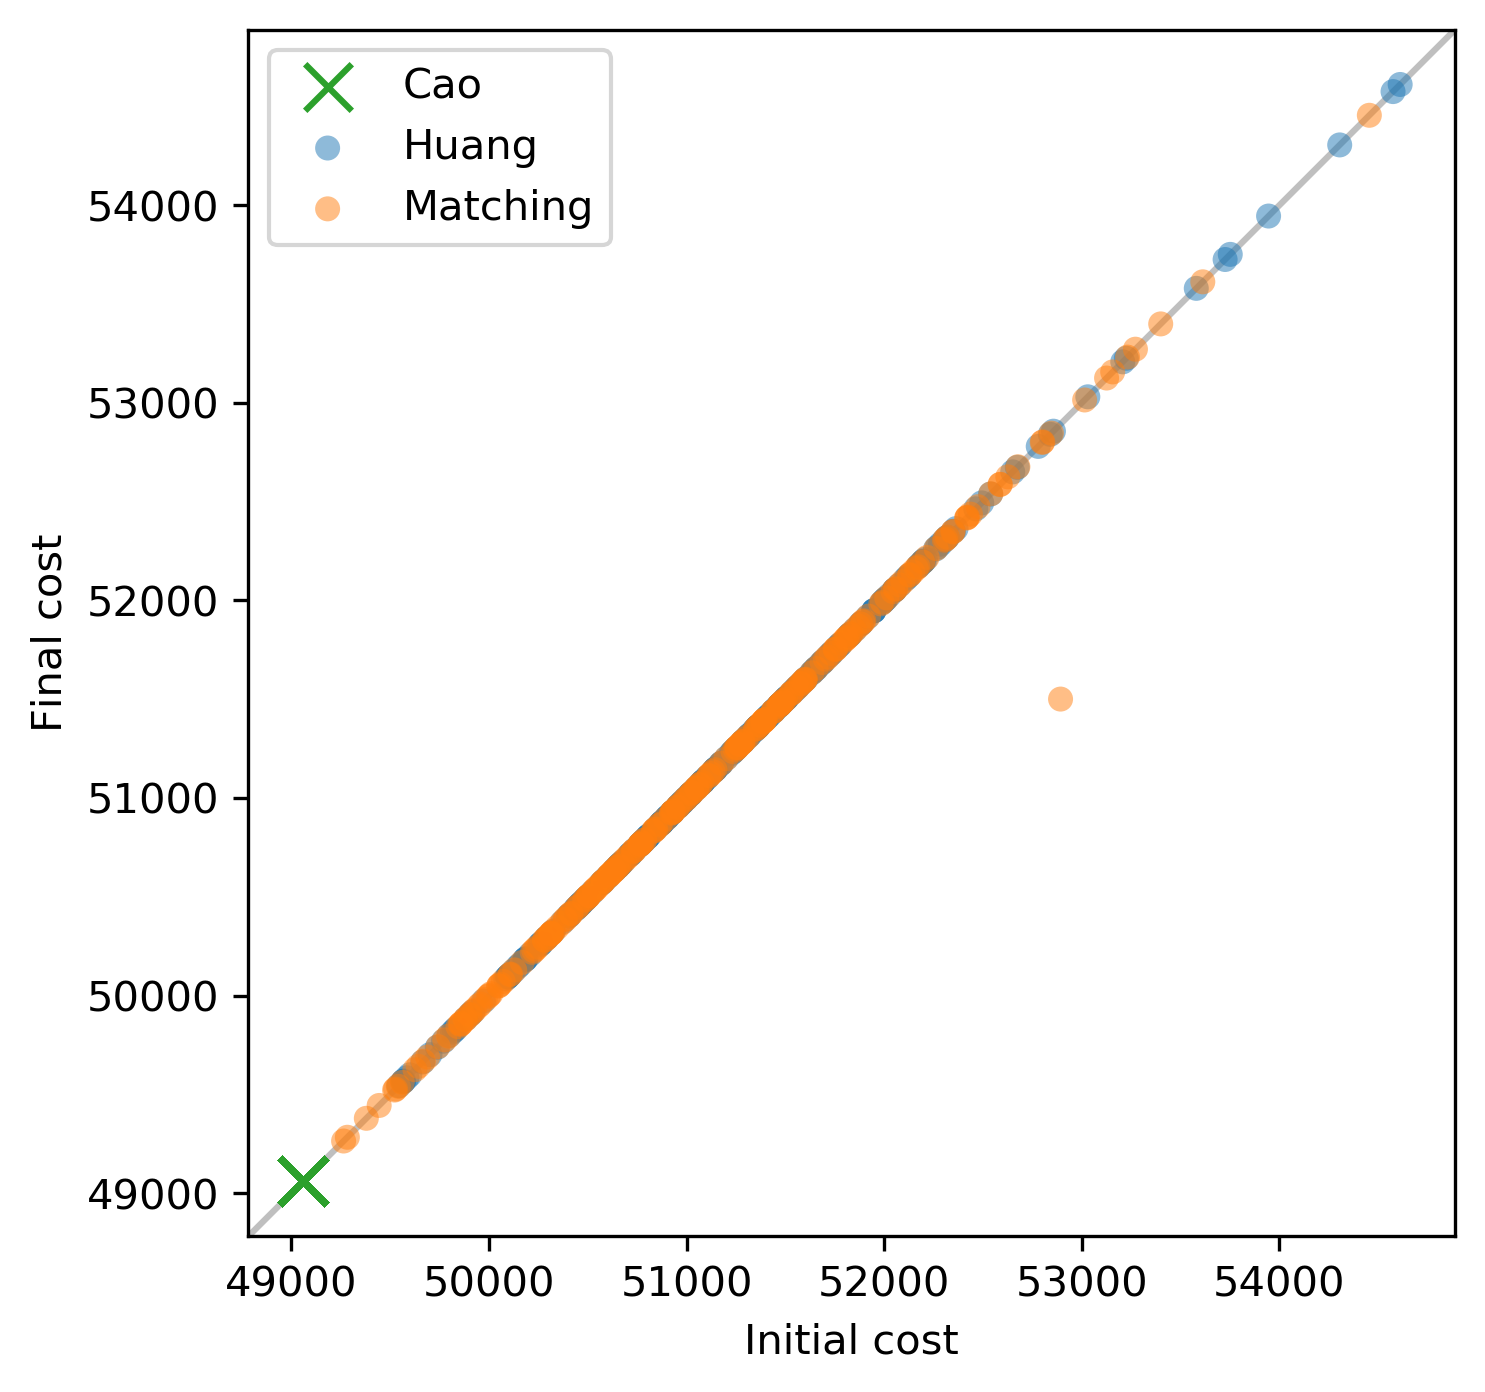

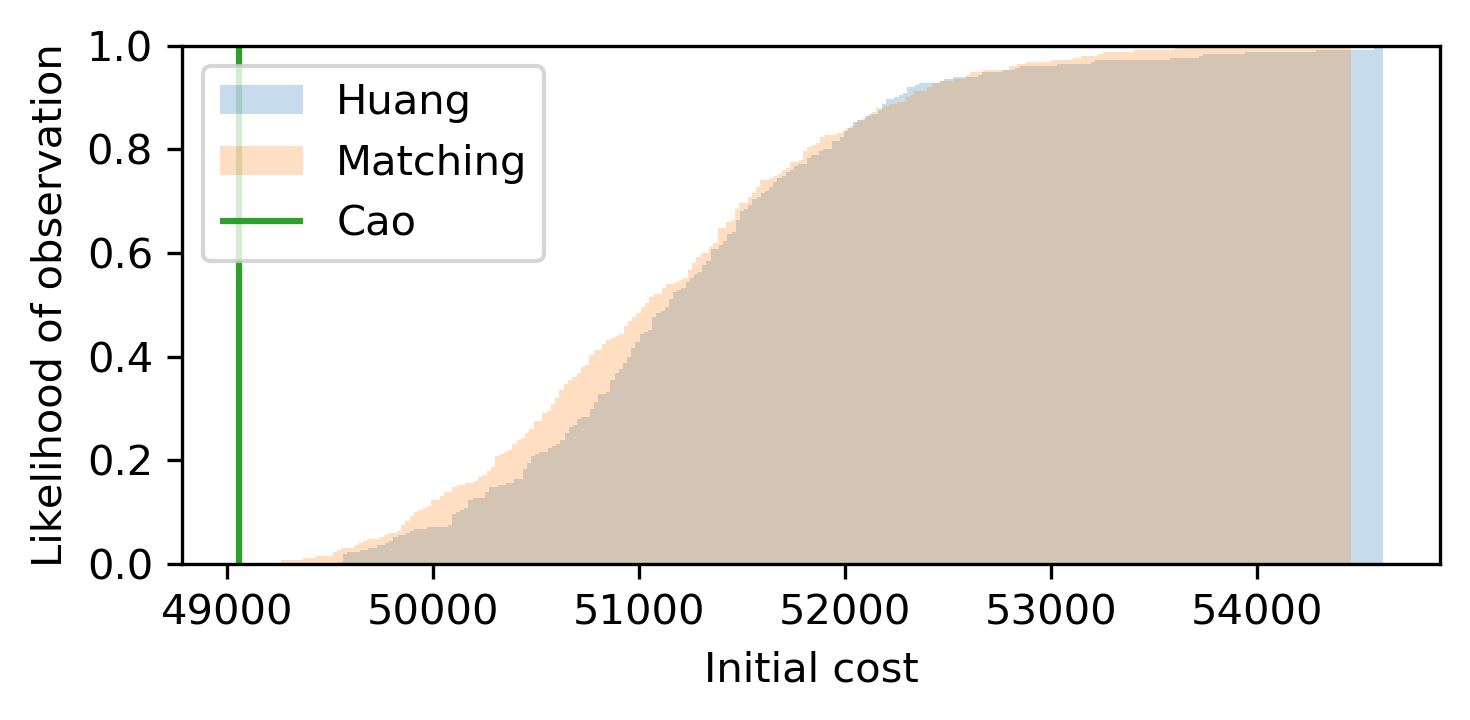

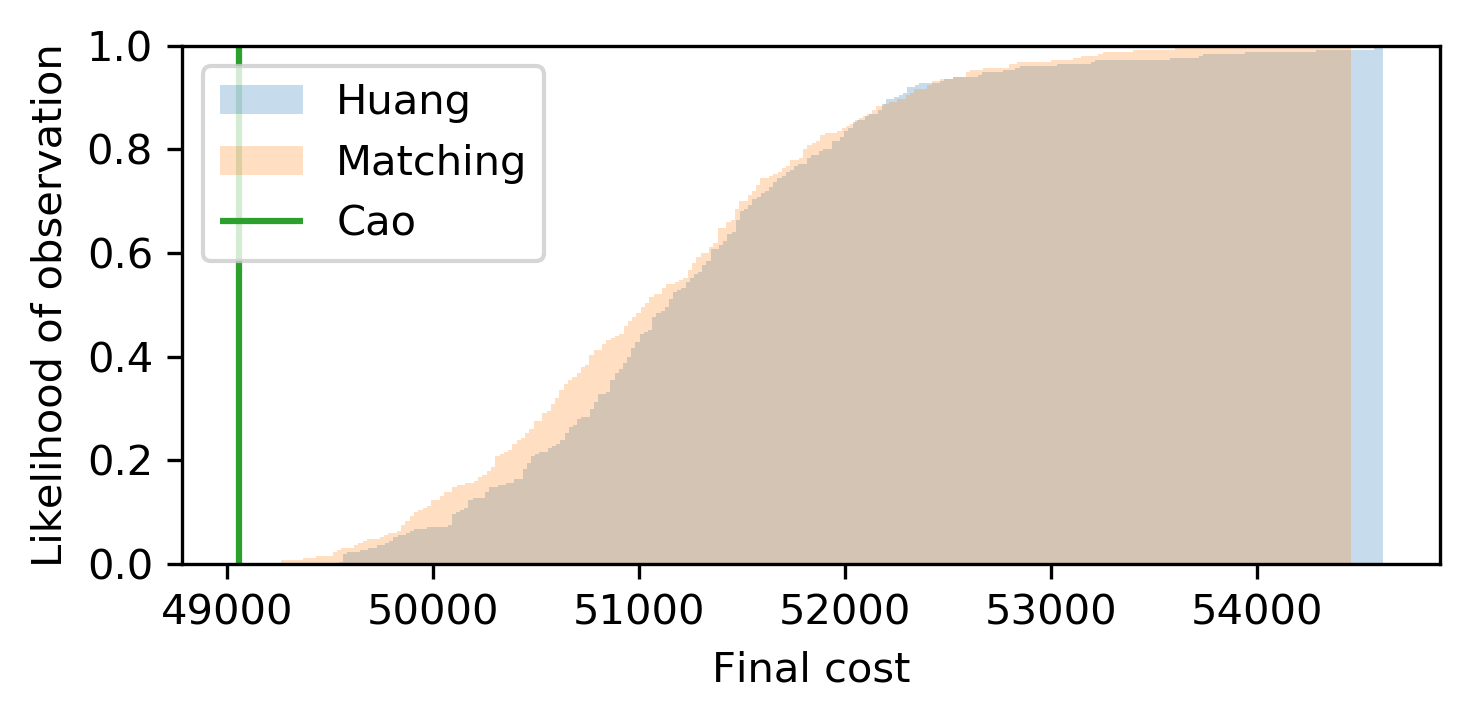

In [6]:
nseeds = 250

with open("../tex/repetitions.tex", "w") as f:
    f.write(str(nseeds))

for root in (
    "elbow/",
    "nclasses/",
):
    for name in (
        "breast_cancer",
        "soybean",
        "mushroom",
        "nursery",
    ):
        scatter_plots(name, f"../data/{root}", destination=f"../img/{root}", nseeds=nseeds)
        for column in (
            "initial_cost",
            "final_cost",
        ):
            empirical_cdf_plots(name, column, f"../data/{root}", destination=f"../img/{root}", nseeds=nseeds)


# Result tables


In [7]:
def get_summary(name, root, destination=None, nseeds=None):

    results = pd.read_csv(f"{root}{name}_results.csv")
    if nseeds:
        results = results[results["seed"] < nseeds]

    means = results.groupby("initialisation")[
        ["initial_cost", "final_cost", "n_iterations", "time"]
    ].mean()

    stds = results.groupby("initialisation")[
        ["initial_cost", "final_cost", "n_iterations", "time"]
    ].std()

    summary = pd.DataFrame(columns=means.columns, index=means.index)
    for j, column in enumerate(means):
        for i, _ in enumerate(means[column]):
            summary.iloc[i, j] = f"{means.iloc[i, j]:.2f} ({stds.iloc[i, j]:.3f})"

    summary.columns = ["Initial cost", "Final cost", "No. iterations", "Time"]
    summary.index = ["Cao", "Huang", "Matching"]

    if destination is not None:
        summary.to_latex(f"{destination}{name}_summary.tex")

    print(f"{name} ({root.split('/')[-2]}) summary:\n", summary, "\n\n")


In [8]:
for root in (
    "elbow/",
    "nclasses/",
):
    for name in (
        "breast_cancer",
        "soybean",
        "mushroom",
        "nursery",
    ):
        get_summary(name, f"../data/{root}", f"../tex/{root}", nseeds=nseeds)


breast_cancer (elbow) summary:
                Initial cost        Final cost No. iterations          Time
Cao         3118.00 (0.000)   2774.00 (0.000)   4.00 (0.000)  0.30 (0.012)
Huang     2856.50 (104.245)  2748.83 (64.514)   2.68 (0.817)  0.22 (0.046)
Matching  2870.11 (101.869)  2752.59 (52.387)   2.72 (0.760)  0.16 (0.021) 


soybean (elbow) summary:
               Initial cost        Final cost No. iterations          Time
Cao        1654.00 (0.000)   1585.00 (0.000)   4.00 (0.000)  0.28 (0.014)
Huang     1829.31 (92.308)  1708.55 (69.740)   3.58 (1.019)  0.28 (0.063)
Matching  1827.76 (86.852)  1711.49 (73.319)   3.42 (0.963)  0.17 (0.022) 


mushroom (elbow) summary:
                  Initial cost          Final cost No. iterations          Time
Cao          20381.00 (0.000)    20376.00 (0.000)   2.00 (0.000)  4.68 (0.205)
Huang     23027.24 (1209.753)  21869.06 (747.766)   2.90 (0.934)  5.11 (1.138)
Matching  23279.36 (1498.324)  21855.50 (751.641)   3.02 (0.936)  2.77 (0.32